In [2]:
import subprocess
import os
import glob
import numpy as np
import pandas as pd
from time import process_time as ptime
import time
from datetime import timedelta

In [3]:
# ffmpeg binary
ffmpeg = "/usr/bin/ffmpeg"

# text directory
text_dir = "../data/raw/text"
labels_dir = "../data/raw/labels"

# labels file
labels_file = "../data/interim/labels/labels.csv"

# audio directories
audio_dir = "../data/raw/audio"
audio_out_dir = "../data/interim/audio"
audio_features_dir = "../data/processed/audio"

In [773]:
len(os.listdir(audio_dir))

3837

In [778]:
def load_all_ratings(labels_dir, split_id_clip = False):
    
    label_files = glob.glob(f"{labels_dir}/*.csv")

    df_list = []

    for filename in label_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        df_list.append(df)


    df_labels = pd.concat(df_list, axis=0, ignore_index=True)

    label_cols = ['Input.VIDEO_ID', 'Input.CLIP',
              'Answer.anger', 'Answer.disgust',
              'Answer.fear', 'Answer.happiness',
              'Answer.sadness', 'Answer.surprise',
              'Answer.sentiment']

    label_new_cols = ['id', 'clip',
                      'anger', 'disgust',
                      'fear', 'happiness',
                      'sadness', 'surprise',
                      'sentiment']
    df_labels = df_labels[label_cols]
    df_labels.columns = label_new_cols

    # drop row all nan
    isna_idx = \
        df_labels.index[df_labels[df_labels.columns[2:]].isna().all(axis=1)]
    df_labels.drop(index=isna_idx, inplace=True)
    # replace remaining nan's with 0
    df_labels = df_labels.replace({np.nan : 0})
    # convert ratings to int
    df_labels[label_new_cols[2:]] = df_labels[label_new_cols[2:]].astype('Int64')
    # set emotions to 0 or 1
    df_labels[label_new_cols[2:-1]] = \
        df_labels[label_new_cols[2:-1]].applymap(lambda x : 1 if x > 0 else 0)

    # if sentiment > 0 convert to positive = 1, elif < 0 convert to negative = 1
    # if none of emotion or sentiment == 1, set none to 1

    df_labels['positive'] = \
        df_labels['sentiment'].map(lambda x : 1 if x > 0 else 0)
    df_labels['negative'] = \
        df_labels['sentiment'].map(lambda x : 1 if x < 0 else 0)

    # drop sentiment column (now in positive/negative)
    df_labels.drop(columns='sentiment', inplace=True)
    
    df_labels['none'] = 0
    none_idx = \
        df_labels[df_labels[df_labels.columns[2:]].sum(axis=1) == 0].index

    df_labels.loc[none_idx,'none'] = 1

    label_new_cols = ['id', 'clip',
                      'anger', 'disgust',
                      'fear', 'happiness',
                      'sadness', 'surprise',
                      'sentiment']
    # df_labels = \
        # df_labels.
    
    # remove '/' from id's
    df_labels['id'] = df_labels['id'].map(lambda x : str(x).split("/")[-1])
    if not split_id_clip:
        df_labels['id'] = df_labels['id'] + '_' + df_labels['clip'].astype(str)
        df_labels.drop(columns = 'clip', inplace = True)
        
        label_new_cols = ['id',
                          'none', 'positive', 'negative',
                          'anger', 'disgust',
                          'fear', 'happiness',
                          'sadness', 'surprise'
                         ]
    else:
        label_new_cols = ['id', 'clip',
                          'none', 'positive', 'negative',
                          'anger', 'disgust',
                          'fear', 'happiness',
                          'sadness', 'surprise'
                         ]
        
    df_labels = df_labels[label_new_cols]
    return df_labels

In [ ]:
def get_all_rated_clips_ids(labels_dir):
    ratings = load_all_ratings(labels_dir)

In [ ]:
def aggregate_labels(labels):
    '''
        aggregate labels to 1 if 2+ ratings of 3 aggree
    '''
    grp_labels = labels.groupby('id').sum()
    display(grp_labels.head(5))
    grp_labels = grp_labels.applymap(lambda x : 1 if x > 1 else 0)
    display(grp_labels.head(5))
    # drop rows where all == 0
    idx = grp_labels[grp_labels.sum(axis =1) == 0].index
    grp_labels.drop(index = idx, inplace=True)
    print(f"{len(idx)} rows dropped")
    print(f"{grp_labels.shape[0]} grouped labels")
    return grp_labels

In [4]:
def get_audio_clip_names(audio_dir):
    clip_names = []
    for i, f in enumerate(os.listdir(audio_dir)):
        if f.endswith(".wav") and os.path.isfile(audio_dir + '/' + f):
            clip_names.append(f.rsplit('.', maxsplit = 1)[0])
    return clip_names

In [5]:
def replace_emotion_by_sentiment(labels):

    new_labels = labels.copy()
    label_names = [e for e in labels.columns.tolist() if e != 'id']

    # mask_positive = labels['positive'] == 1
    mask_happy = new_labels['happiness'] == 1
    idx = new_labels[(mask_happy)].index
    num_masked = \
        new_labels[(mask_happy)]['id'].count()
        # new_labels[(mask_positive) & (mask_happy) & mask_2_labels]['id'].count()
    unique_ids = \
        new_labels[(mask_happy)]['id'].unique()
        # new_labels[(mask_positive) & (mask_happy) & mask_2_labels]['id'].unique()
    print(f"happy ratings    : {num_masked}")
    print(f"comments affected: {len(unique_ids)}")
    new_labels.loc[idx, 'positive'] = 1
    # new_labels.drop(columns = ['happiness'], inplace = True)

    mask_anger = new_labels['anger'] == 1
    mask_disgust = new_labels['disgust'] == 1
    mask_fear = new_labels['fear'] == 1
    mask_sadness = new_labels['sadness'] == 1
    mask = (mask_anger) | (mask_disgust) | (mask_fear) | (mask_sadness)
    idx = new_labels[(mask)].index
    num_masked = \
        new_labels[(mask)]['id'].count()
    unique_ids = \
        new_labels[(mask)]['id'].unique()

    print(f"negative emotion ratings    : {num_masked}")
    print(f"comments affected           : {len(unique_ids)}")
    new_labels.loc[idx, 'negative'] = 1
    
    drop_cols = ['happiness',
                 'anger', 'disgust',
                 'fear', 'sadness',
                 'surprise']
    new_labels.drop(columns = drop_cols, inplace = True)
    # new_labels['anger'] = 0
    # new_labels['disgust'] = 0
    # new_labels['fear'] = 0
    # new_labels['sadness'] = 0

    return new_labels

In [547]:
def extract_audio_features_mean(audio_file, n_mfccs=13, rms=False, zrc=False):
    import librosa
    samples, srate = \
        librosa.load(audio_file, res_type='kaiser_fast')

    audio_features = None
    feature_names = []
    if rms:
        feature_names += ['rms']
        audio_features = \
            np.mean(librosa.feature.rms(y=samples).T, axis=0)
            # librosa.feature.rms(y=samples)
            
        # print(audio_features)
        # audio_features = np.append(audio_features, rms)
    if zrc:
        feature_names += ['zrc']
        zrc = \
            np.mean(librosa.feature.zero_crossing_rate(y=samples).T,
                    axis=0)
        # print(zrc)
        # print(type(audio_features))
        if isinstance(audio_features, np.ndarray):
            audio_features = np.append(audio_features, zrc)
        else:
            audio_features = zrc
        # print(audio_features)
    
    feature_names += ['mfcc_' + str(x) for x in range(1, n_mfccs + 1)]
    mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=srate,
                                         n_mfcc=n_mfccs).T, axis=0)
    # print(type(audio_features))
    # print(mfccs)
    if isinstance(audio_features, np.ndarray):
        audio_features = np.append(audio_features, mfccs)
    else:
        audio_features = mfccs
    return audio_features, feature_names

In [5]:
def extract_audio_features_median(audio_file, len_secs='full',
                           n_mfccs=13, rms=False, zrc=False):

    import librosa
    samples, srate = \
        librosa.load(audio_file, sr=None)
    # normalize audio_file
    # samples = (samples - samples.mean()) / samples.std()
    
    if len_secs != 'full':
        num_samples = srate * len_secs
        if num_samples > len(samples):
            # samples = samples[:num_samples]
            samples = samples[-num_samples:]
    
    audio_features = None
    feature_names = []
    if rms:
        feature_names += ['rms']
        audio_features = \
            np.median(librosa.feature.rms(y=samples).T, axis=0)
            # librosa.feature.rms(y=samples)
            
        # print(audio_features)
        # audio_features = np.append(audio_features, rms)
    if zrc:
        feature_names += ['zrc']
        zrc = \
            np.median(librosa.feature.zero_crossing_rate(y=samples).T,
                    axis=0)
            # print(zrc)
            # print(type(audio_features))
            
        if isinstance(audio_features, np.ndarray):
            audio_features = np.append(audio_features, zrc)
        else:
            audio_features = zrc
        # print(audio_features)
    
    feature_names += ['mfcc_' + str(x) for x in range(1, n_mfccs + 1)]
    S = librosa.feature.melspectrogram(y=samples,
                                   sr=srate, n_mels=64, #128,
                                   fmax=8000, hop_length=512)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfccs)
    mfccs = np.median(mfccs, axis=1)
    # test norm before median
    #mfccs = \
    #    speechpy.processing.cmvn(mfccs.T, variance_normalization=True)
    # print(mfccs.shape)
    #mfccs = np.median(mfccs, axis=0)
    # mfccs = speechpy.processing.cmvn(mfccs, variance_normalization=True)

    # mfccs = np.median(librosa.feature.mfcc(y=samples, sr=srate,
    #                                     n_mfcc=n_mfccs).T, axis=0)
    # print(type(audio_features))
    # print(mfccs)
    if isinstance(audio_features, np.ndarray):
        audio_features = np.append(audio_features, mfccs)
    else:
        audio_features = mfccs
    return audio_features, feature_names

In [824]:
def extract_features_from_dir(audio_dir, file_names=None,
                              n_mfccs=13, rms=True, zrc=True,
                              show_progress=True):
    not_files = []
    audio_features = {}
    stime = time.time()# ptime()
    cnt = 0
    if file_names is None:
        file_names = (os.listdir(audio_dir))
    num_files = len(file_names) # len(os.listdir(audio_dir))
    # for i, f in enumerate(os.listdir(audio_dir)):
    for i, f in enumerate(file_names):
        if f.endswith(".wav") and os.path.isfile(audio_dir + '/' + f):
            # print(audio_dir + '/' + f)
            clip_features, fnames = \
                extract_audio_features_median(audio_dir + '/' + f, n_mfccs, rms, zrc)
                # extract_features(audio_dir + '/' + f, n_mfccs, rms, zrc)
            audio_features[f.rsplit('.', maxsplit = 1)[0]] = clip_features
        else:
            not_files.append(f)
            # print(f"{f} not in audio_dir")

        if show_progress:
            if i % 10 == 0 and i != 0:
                print('.', end = '')
                if i % 500 == 0:
                    print(f" {i} of {num_files} files processed")

    audio_features = pd.DataFrame(audio_features).T
    audio_features.columns = fnames #['mfcc_' + str(x) for x in range(1, n_mfccs + 1)]
    etime = time.time() # ptime()
    proc_time = timedelta(seconds = etime - stime)
    print(f"\n\n{audio_features.shape[0]} files processed, tot time: {proc_time}")
    return audio_features, not_files

In [1]:
def extract_audio_features_from_dir(audio_dir, file_names=None,
                                    agg='median', len_secs='full',
                                    n_mfccs=20, rms=False, zrc=False,
                                    show_progress=True):
    not_files = []
    audio_features = {}
    stime = time.time()# ptime()
    cnt = 0
    if file_names is None:
        file_names = glob.glob(f"{audio_dir}/*.wav")
        # print(file_names[:5])
        # file_names = (os.listdir(audio_dir))
    else:
        file_names = [audio_dir + '/' + f + '.wav' for f in file_names]
    num_files = len(file_names) # len(os.listdir(audio_dir))
    # for i, f in enumerate(os.listdir(audio_dir)):
    for i, f in enumerate(file_names):
        # if f.endswith(".wav") and os.path.isfile(audio_dir + '/' + f):
            # print(audio_dir + '/' + f)
        if agg == 'median':
            clip_features, fnames = \
                extract_audio_features_median(f, len_secs, n_mfccs, rms, zrc)
                # # extract_audio_features_median(audio_dir + '/' + f,
        else:
            clip_features, fnames = \
                extract_audio_features_mean(f, len_secs, n_mfccs, rms, zrc)
                # extract_audio_features_mean(audio_dir + '/' + f,
        # audio_features[f.rsplit('.', maxsplit = 1)[0]] = clip_features
        # check new split !!!!!!
        clip_id = f.rsplit('.', maxsplit = 1)[0].rsplit('/', maxsplit = 1)[-1]
        audio_features[clip_id] = clip_features
        # audio_features[f.rsplit('.', maxsplit = 1)[0]] = clip_features
        # else:
        #    not_files.append(f)
            # print(f"{f} not in audio_dir")

        if show_progress:
            if i % 10 == 0 and i != 0:
                print('.', end = '')
                if i % 500 == 0:
                    print(f" {i} de {num_files} fichiers")

    audio_features = pd.DataFrame(audio_features).T
    audio_features.columns = fnames #['mfcc_' + str(x) for x in range(1, n_mfccs + 1)]
    etime = time.time() # ptime()
    proc_time = timedelta(seconds = round(etime - stime))
    print(f"\n\n{audio_features.shape[0]} fichiers extraits: {proc_time} (h:mm:ss)")
    return audio_features

In [6]:
mfcc40_4sec_median = \
    extract_audio_features_from_dir(audio_out_dir, file_names=None,
                                    agg='median', len_secs=4,
                                    n_mfccs=40, rms=False, zrc=False,
                                    show_progress=True)

.................................................. 500 de 23259 fichiers
.................................................. 1000 de 23259 fichiers
.................................................. 1500 de 23259 fichiers
.................................................. 2000 de 23259 fichiers
.................................................. 2500 de 23259 fichiers
.................................................. 3000 de 23259 fichiers
.................................................. 3500 de 23259 fichiers
.................................................. 4000 de 23259 fichiers
.................................................. 4500 de 23259 fichiers
.................................................. 5000 de 23259 fichiers
.................................................. 5500 de 23259 fichiers
.................................................. 6000 de 23259 fichiers
.................................................. 6500 de 23259 fichiers
.......................................

/home/graymo/.cache/pypoetry/virtualenvs/emotion-eq9CsLJl-py3.8/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)


....................................... 18500 de 23259 fichiers
.................................................. 19000 de 23259 fichiers
.................................................. 19500 de 23259 fichiers
.................................................. 20000 de 23259 fichiers
.................................................. 20500 de 23259 fichiers
.................................................. 21000 de 23259 fichiers
.................................................. 21500 de 23259 fichiers
.................................................. 22000 de 23259 fichiers
.................................................. 22500 de 23259 fichiers
.................................................. 23000 de 23259 fichiers
.........................

23259 fichiers extraits: 0:04:38 (h:mm:ss)


In [7]:
mfcc40_4sec_median.to_csv("./mfcc40_4sec_median.csv", header=True, index=True)

In [1145]:
def gen_mfcc_spectro(audio_file, len_secs = 2,
                     fmax=8000, hop_len = 1024, end_pad_secs=0.1):
    full_samples, srate = \
        librosa.load(audio_file, sr=None)
    # standardize
    # full_samples = (full_samples - full_samples.mean()) / full_samples.std()
    
    num_samples = srate * len_secs
    end_pad = int(srate * end_pad_secs)
    
    if len(full_samples) < num_samples:
        zero_pad = np.zeros(num_samples - len(full_samples))
        samples = np.concatenate((zero_pad, full_samples), axis=0)
    elif len(full_samples) > num_samples + end_pad:
        samples = full_samples[len(full_samples) - num_samples - end_pad:-end_pad]
    else:
        # print("else")
        samples = full_samples[-num_samples:]
    # print(len(samples))
    S = librosa.feature.melspectrogram(y=samples,
                                   sr=srate, n_mels=64, #128,
                                   fmax=fmax, hop_length=hop_len)
    mfcc_spectro = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=20)#,
                                    #hop_length=1024)#, htk=True)
    #mfcc_spectro = sklearn.preprocessing.scale(mfcc_spectro, axis=1)
    # plt.figure(figsize=(10,8))
    # librosa.display.specshow(mfcc_spectro[:, :], sr=test_sr / (hop_len/512),
    #                         x_axis='time')
    #plt.show()
    # print(mfcc_spectro.shape)
    return mfcc_spectro

In [1152]:
def extract_mfcc_spectros_from_dir(audio_dir, file_names=None,
                                    len_secs=3, show_progress=True):
    not_files = []
    audio_features = {}
    stime = time.time()# ptime()
    cnt = 0
    if file_names is None:
        file_names = glob.glob(f"{audio_dir}/*.wav")
        # print(file_names[:5])
        # file_names = (os.listdir(audio_dir))
    else:
        file_names = [audio_dir + '/' + f + '.wav' for f in file_names]
    num_files = len(file_names) # len(os.listdir(audio_dir))
    # for i, f in enumerate(os.listdir(audio_dir)):
    mfcc_spectros = []
    clip_ids = []
    for i, f in enumerate(file_names):
        # print(f)
        clip_id = f.rsplit('.', maxsplit = 1)[0].rsplit('/', maxsplit = 1)[-1]
        # try:
        clip_mfcc_spectro = \
                    gen_mfcc_spectro(f, len_secs = len_secs,
                                     fmax=8000, hop_len = 512,
                                     end_pad_secs=0.1)
        clip_ids.append(clip_id)
        mfcc_spectros.append(clip_mfcc_spectro)
        #except:
        #    print(f"error : {clip_id}")
        
        
        if show_progress:
            if i % 10 == 0 and i != 0:
                print('.', end = '')
                if i % 500 == 0:
                    print(f" {i} de {num_files} fichiers")

    mfcc_spectros = np.array(mfcc_spectros)
    etime = time.time() # ptime()
    proc_time = timedelta(seconds = round(etime - stime))
    print(f"\n{mfcc_spectros.shape[0]} fichiers extraits: {proc_time} (h:mm:ss)")
    return mfcc_spectros, np.array(clip_ids)

In [1149]:
#labels = sentiment_labels.copy()
labels = only_sentiment_labels.copy()
# labels = emotion_labels.copy()
# labels = med_senti_labels.copy()
labels.sum(axis=0)

none        6560
positive    6548
negative    4231
dtype: int64

In [1153]:
audio_file_names = labels.index.tolist()
print(len(audio_file_names))

17339


In [1154]:
mfcc_spec_4sec, mspec_4sec_clip_ids = \
    extract_mfcc_spectros_from_dir(audio_out_dir,
                                   file_names = audio_file_names,
                                   len_secs=4)

.................................................. 500 de 17339 fichiers
.................................................. 1000 de 17339 fichiers
.................................................. 1500 de 17339 fichiers
.................................................. 2000 de 17339 fichiers
.................................................. 2500 de 17339 fichiers
.................................................. 3000 de 17339 fichiers
.................................................. 3500 de 17339 fichiers
.................................................. 4000 de 17339 fichiers
.................................................. 4500 de 17339 fichiers
.................................................. 5000 de 17339 fichiers
.................................................. 5500 de 17339 fichiers
.................................................. 6000 de 17339 fichiers
.................................................. 6500 de 17339 fichiers
.......................................

In [1155]:
print(mfcc_spec_4sec.shape)
print(len(mspec_4sec_clip_ids))

(17339, 20, 126)
17339


In [1175]:
Xtrain, Xtest, ytrain, ytest = \
    train_test_split(mfcc_spec_4sec, labels, test_size=0.2,
                     stratify=labels.values.argmax(axis=1))
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(13871, 20, 126)
(3468, 20, 126)
(13871, 3)
(3468, 3)


In [1160]:
Xtrain[0,:,100]

array([-1.43254377e+02,  5.45905871e+01,  1.77960372e+00,  6.92865428e+00,
       -3.37237339e+00,  1.46709135e+00, -4.14464466e-01,  9.73582847e+00,
        5.53207239e-01,  8.76386568e+00,  4.84243528e+00,  6.77660563e+00,
       -1.34747056e-01, -1.42605432e-01, -1.90956393e+00,  3.20604847e+00,
       -4.72190845e+00,  8.21838134e+00, -4.39742914e+00,  5.70058703e+00])

In [1194]:
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss
from torch.nn import Sequential, Conv2d, MaxPool2d, Module
from torch.nn import Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam

In [1176]:
Xtrain = \
    Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1], Xtrain.shape[2]).astype(float)
Xtrain = torch.from_numpy(Xtrain)

Xtest = \
    Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1], Xtest.shape[2]).astype(float)
Xtest = torch.from_numpy(Xtest)

# converting the target into torch format
ytrain = ytrain.values.argmax(axis=1).astype(int)
ytrain = torch.from_numpy(ytrain)

ytest = ytest.values.argmax(axis=1).astype(int)
ytest = torch.from_numpy(ytest)


# shape of training data
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

torch.Size([13871, 1, 20, 126])
torch.Size([3468, 1, 20, 126])
torch.Size([13871])
torch.Size([3468])


In [1195]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Flatten()
        )

        n_channels = self.cnn_layers(torch.empty(1, 1, 20, 126)).size(-1)
        self.linear_layers = Sequential(
            Linear(n_channels, 3)
            # Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [1196]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
#if torch.cuda.is_available():
#    model = model.cuda()
#    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=620, out_features=3, bias=True)
  )
)


In [1197]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(Xtrain), Variable(ytrain)
    # x_train, y_train = Xtrain, ytrain
    # getting the validation set
    x_val, y_val = Variable(Xtest), Variable(ytest)
    # x_val, y_val = Xtest, ytest
    # converting the data into GPU format
    #if torch.cuda.is_available():
    #    x_train = x_train.cuda()
    #    y_train = y_train.cuda()
    #    x_val = x_val.cuda()
    #    y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.float())
    output_val = model(x_val.float())

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# defining the number of epochs
n_epochs = 70
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

stime = time.time()
# training the model
for epoch in range(n_epochs):
    train(epoch)
print(f"Train time: {timedelta(seconds = round(time.time() - stime))}")

Epoch :  1 	 loss : tensor(1.9441, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(1.6176, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.3392, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.1253, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.1498, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.0822, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.0894, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(1.0992, grad_fn=<NllLossBackward0>)


In [1207]:
from sklearn.metrics import accuracy_score
with torch.no_grad():
    output = model(Variable(Xtrain).float())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(Variable(ytrain), predictions)

0.37308052771970296

In [1189]:
13871 * 620

8600020

In [1162]:
ytrain.head()

,none,positive,negative
id,,,
220548_18,0,0,1
238645_22,1,0,0
220548_7,1,0,0
9pzn93kdP_g_12,1,0,0
266366_18,0,0,1


In [1083]:
def test_speechpy(audio_file):
    signal, fs = \
        librosa.load(audio_file, sr=None)

    mfcc = \
        speechpy.feature.mfcc(signal, sampling_frequency=fs,
                              frame_length=0.06, frame_stride=0.03,
                              num_filters=40, fft_length=512,
                              low_frequency=0, high_frequency=8000)
    print(f"mfcc shape : {mfcc.shape}")
    mfcc_cmvn = \
        speechpy.processing.cmvn(mfcc,variance_normalization=True)
        # speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
    print('mfcc(mean + variance normalized) feature shape=', mfcc_cmvn.shape)
    return mfcc, mfcc_cmvn

In [1084]:
mfcc_t, cmvn_t = test_speechpy(f"{audio_out_dir}/ZZzdvUdOTww_6.wav")

mfcc shape : (322, 13)
mfcc(mean + variance normalized) feature shape= (322, 13)


In [1085]:
mfcc_t[0,:]

array([-3.67753412,  6.52812579,  5.03452861,  2.95069178,  0.14795272,
        0.19027283, -1.74697572,  0.21193462, -2.37730696,  0.26424378,
        1.35034403,  0.85071493,  2.43829786])

In [1086]:
cmvn_t[0,:]

array([-1.2247    ,  0.66510024,  1.20265181,  1.07659312,  0.89492692,
        0.89971368, -1.03733615,  0.13579794, -0.9810279 ,  0.3110504 ,
        1.1071976 ,  0.99836218,  1.4235828 ])

In [1108]:

shit_test = \
    extract_audio_features_from_dir(audio_out_dir,
                                    file_names = ['ZZzdvUdOTww_6.wav',
                                                  'ZZzdvUdOTww_5.wav'],
                                    len_secs=7, n_mfccs=40)



2 fichiers extraits: 0:00:00 (h:mm:ss)


In [1109]:
shit_test

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
ZZzdvUdOTww_6,-132.788879,49.931824,-21.461443,11.115282,-7.928411,-3.434653,-22.619923,-12.767811,-6.566501,-6.378335,...,-1.141275,0.319903,0.021215,-1.096828,-1.131897,-0.291363,1.397075,1.809059,-1.252593,-1.283837
ZZzdvUdOTww_5,-116.906128,43.929367,-36.894726,13.715577,-15.977469,-7.243235,-24.517042,-7.471699,-5.330890,-7.206280,...,-3.045218,-2.407599,0.325554,0.768542,-0.523832,-1.917225,0.217673,2.627570,0.414611,-0.121482


In [1012]:
audio_features_7sec_median

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
ZZzdvUdOTww_6,-132.788879,49.931824,-21.461443,11.115282,-7.928411,-3.434653,-22.619923,-12.767811,-6.566501,-6.378335,...,-1.141275,0.319903,0.021215,-1.096828,-1.131897,-0.291363,1.397075,1.809059,-1.252593,-1.283837
ZZzdvUdOTww_5,-116.906128,43.929367,-36.894726,13.715577,-15.977469,-7.243235,-24.517042,-7.471699,-5.330890,-7.206280,...,-3.045218,-2.407599,0.325554,0.768542,-0.523832,-1.917225,0.217673,2.627570,0.414611,-0.121482


In [1093]:
audio_features_7sec_median = \
    extract_audio_features_from_dir(audio_out_dir, len_secs=7, n_mfccs=40)

.................................................. 500 de 23259 fichiers
.................................................. 1000 de 23259 fichiers
.................................................. 1500 de 23259 fichiers
.................................................. 2000 de 23259 fichiers
.................................................. 2500 de 23259 fichiers
.................................................. 3000 de 23259 fichiers
.................................................. 3500 de 23259 fichiers
.................................................. 4000 de 23259 fichiers
.................................................. 4500 de 23259 fichiers
.................................................. 5000 de 23259 fichiers
.................................................. 5500 de 23259 fichiers
.................................................. 6000 de 23259 fichiers
.................................................. 6500 de 23259 fichiers
.......................................

/home/graymo/.cache/pypoetry/virtualenvs/emotion-eq9CsLJl-py3.8/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)


...................................... 18500 de 23259 fichiers
.................................................. 19000 de 23259 fichiers
.................................................. 19500 de 23259 fichiers
.................................................. 20000 de 23259 fichiers
.................................................. 20500 de 23259 fichiers
.................................................. 21000 de 23259 fichiers
.................................................. 21500 de 23259 fichiers
.................................................. 22000 de 23259 fichiers
.................................................. 22500 de 23259 fichiers
.................................................. 23000 de 23259 fichiers
.........................

23259 fichiers extraits: 0:04:38 (h:mm:ss)


In [1094]:
audio_features_7sec_median.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
MPRqaQqrd9Y_7,0.081081,0.112684,-0.069338,0.146101,-0.184123,0.084854,0.028828,-0.048138,-0.065247,0.031940,...,-0.108873,-0.199542,-0.142335,-0.152613,0.016499,0.013209,-0.001824,0.022771,0.012212,0.094283
UlTJmndbGHM_4,0.004279,-0.048320,0.017125,0.068671,-0.024411,0.027486,0.036282,-0.025163,0.055433,0.061063,...,0.074803,0.000686,0.094405,-0.010989,-0.056813,-0.097431,-0.040566,-0.000072,0.003655,0.035351
hjBQmIWiWgw_2,0.214421,0.121466,-0.050993,0.101781,0.179639,0.125105,0.055836,0.119115,0.090840,0.141714,...,0.056626,-0.013629,0.074136,0.080012,0.043028,0.037999,-0.007328,-0.026470,0.014421,0.005840
9zWeMrfr-l0_0,0.251293,0.005175,0.199574,-0.140194,0.090230,0.097648,-0.294473,0.080060,-0.118735,-0.048792,...,-0.102098,-0.081901,-0.003115,-0.248256,-0.172884,-0.134931,0.064587,0.100128,-0.052376,-0.119685
31197_2,-0.310935,-0.249874,0.377811,-0.335458,0.361859,0.163141,0.379143,0.280348,0.312033,0.209711,...,-0.054553,0.048016,-0.047994,-0.069776,-0.036173,-0.067106,-0.056549,-0.095872,0.040743,-0.064393


In [1055]:
mfcc_7sec_median_norm = speechpy.processing.cmvn(audio_features_7sec_median,
                                                 variance_normalization=True)
mfcc_7sec_median_norm.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
MPRqaQqrd9Y_7,-0.409384,0.679881,-0.377814,-1.062383,-2.051113,-1.214636,0.369122,0.210121,-1.193922,-0.151493,...,1.892269,0.342281,1.252072,1.170634,1.585012,-1.093119,0.461973,0.084133,1.190212,-0.602716
UlTJmndbGHM_4,2.455690,-1.102014,1.249854,-0.074631,1.427342,2.405908,1.666515,2.085172,1.535833,2.009281,...,-0.346196,0.152205,0.815143,0.250301,0.456004,1.446491,-0.083499,-1.374225,-0.464210,0.584546
hjBQmIWiWgw_2,-0.647552,-0.013620,0.169642,-1.936651,0.503626,-0.242121,-2.149063,-1.068102,-1.738495,0.972543,...,-0.384145,-0.684194,-0.485483,-0.797545,-0.976766,-0.387013,-0.435882,0.098396,-0.148719,0.405212
9zWeMrfr-l0_0,-0.276874,-0.543789,0.742379,0.279542,0.922112,-1.816921,0.068509,0.515945,-1.703664,-0.280334,...,0.348793,-0.555141,-0.070136,-0.451934,-0.816474,-0.382107,-0.479945,-0.146851,0.610949,0.461135
31197_2,-0.156620,1.043290,-1.751162,4.077505,-1.143659,3.472221,1.754817,1.331279,2.759663,-0.126440,...,0.229719,-0.117726,-0.832802,0.824195,-0.788074,0.294654,-0.680689,0.561623,-0.427276,-0.999401


In [939]:
audio_features_3sec_median = \
    extract_audio_features_from_dir(audio_out_dir, len_secs=3, n_mfccs=40)

.................................................. 500 de 23259 fichiers
.................................................. 1000 de 23259 fichiers
.................................................. 1500 de 23259 fichiers
.................................................. 2000 de 23259 fichiers
.................................................. 2500 de 23259 fichiers
.................................................. 3000 de 23259 fichiers
.................................................. 3500 de 23259 fichiers
.................................................. 4000 de 23259 fichiers
.................................................. 4500 de 23259 fichiers
.................................................. 5000 de 23259 fichiers
.................................................. 5500 de 23259 fichiers
.................................................. 6000 de 23259 fichiers
.................................................. 6500 de 23259 fichiers
.......................................

In [955]:
audio_features_3sec_median.to_csv("./mfcc40_median_3sec.csv", header=True, index=True)

In [942]:
audio_features_3sec_median.index = \
    audio_features_3sec_median.index.map(lambda x : x.rsplit('/', maxsplit=1)[-1])

In [943]:
audio_features_3sec_median.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
MPRqaQqrd9Y_7,-238.477798,116.482941,-16.343117,13.451738,-20.161373,-10.331965,-14.032530,3.187353,-8.783220,-4.770639,...,0.175206,-0.482796,1.425903,1.884764,0.493000,0.529950,1.037738,1.994728,-0.325253,-1.274732
UlTJmndbGHM_4,-53.425961,94.492218,-19.986244,47.588348,-21.567051,40.110077,-9.876991,21.592289,-3.903989,11.753240,...,-1.387760,-0.199772,-1.833252,-1.971496,0.220655,-1.211483,1.755036,-1.856162,2.457587,-0.118698
hjBQmIWiWgw_2,-247.953888,101.138443,-9.910642,7.709038,-13.915911,10.742346,-22.425343,-8.783762,-15.749350,-6.562918,...,-3.128196,-3.294880,-1.202057,-2.194178,-1.391237,-2.352279,-0.927700,-2.602970,-1.094968,-1.410288
9zWeMrfr-l0_0,-227.373215,89.073639,-9.827379,26.472038,2.726988,1.796814,-16.575569,8.506326,-8.254383,-6.067927,...,-0.133548,-0.343467,-0.757080,-0.810546,-0.412276,-1.497693,-0.009953,-1.921595,-1.485501,-1.057941
31197_2,-219.160126,122.945648,-42.745243,51.231842,8.988420,-1.754196,27.006639,-5.793803,10.785469,6.574906,...,-3.564412,-0.184192,-1.412041,-0.797373,0.196932,-2.414317,0.634682,-0.541945,-0.924508,-0.020378


In [1013]:
import speechpy

In [1014]:
mfcc_3sec_median_norm = speechpy.processing.cmvn(audio_features_3sec_median)

In [1015]:
mfcc_3sec_median_norm.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
MPRqaQqrd9Y_7,-30.692856,12.165039,3.369089,-14.254330,-11.523467,-16.386036,-2.498474,2.298889,-0.529881,-5.023050,...,1.382461,0.438674,1.787483,3.224348,0.316870,1.959954,0.747243,3.272803,-0.451976,-0.355724
UlTJmndbGHM_4,154.358978,-9.825684,-0.274038,19.882280,-12.929145,34.056007,1.657064,20.703825,4.349349,11.500829,...,-0.180505,0.721698,-1.471672,-0.631912,0.044525,0.218521,1.464541,-0.578086,2.330863,0.800311
hjBQmIWiWgw_2,-40.168945,-3.179459,9.801564,-19.997030,-5.278005,4.688275,-10.891287,-9.672226,-7.496011,-6.815329,...,-1.920941,-2.373410,-0.840477,-0.854595,-1.567367,-0.922275,-1.218195,-1.324894,-1.221691,-0.491280
9zWeMrfr-l0_0,-19.588272,-15.244263,9.884827,-1.234030,11.364894,-4.257257,-5.041513,7.617862,-0.001044,-6.320338,...,1.073706,0.578004,-0.395500,0.529038,-0.588406,-0.067689,-0.300448,-0.643520,-1.612224,-0.138933
31197_2,-11.375183,18.627747,-23.033037,23.525774,17.626328,-7.808268,38.540695,-6.682266,19.038807,6.322495,...,-2.357158,0.737278,-1.050461,0.542210,0.020802,-0.984313,0.344187,0.736130,-1.051232,0.898630


In [ ]:
def get_labeled_clips(df_labels):
    '''
        df_labels : DataFrame from load_aggregated_labels
    '''
    labeled_clips = {}

    uniq_ids = sorted(list(df_labels['id'].unique()))
    for i in uniq_ids:
        labeled_clips[i] = \
            sorted(
                df_labels[df_labels['id'] == i]['clip'].astype(int).to_list()
            )
    return labeled_clips

In [825]:
median_audio_features = \
    extract_features_from_dir(audio_out_dir,
                              n_mfccs=40, rms=True, zrc=True,
                              show_progress=True)

.................................................. 500 of 21600 files processed
.................................................. 1000 of 21600 files processed
.................................................. 1500 of 21600 files processed
.................................................. 2000 of 21600 files processed
.................................................. 2500 of 21600 files processed
.................................................. 3000 of 21600 files processed
.................................................. 3500 of 21600 files processed
.................................................. 4000 of 21600 files processed
.................................................. 4500 of 21600 files processed
.................................................. 5000 of 21600 files processed
.................................................. 5500 of 21600 files processed
.................................................. 6000 of 21600 files processed
.............................

In [827]:
# median_audio_features = median_audio_features[0]
median_audio_features.to_csv("./features_median_40mfccs.csv", header=True, index=True)

In [807]:
def get_labeled_clips(labels_dir):
    '''
        df_labels : DataFrame from load_aggregated_labels
    '''
    labeled_clips = {}
    labels = load_all_ratings(labels_dir, split_id_clip=True)

    labels = labels.drop_duplicates(subset=['id','clip'])

    uniq_ids = sorted(list(labels['id'].unique()))
    for i in uniq_ids:
        labeled_clips[i] = \
            sorted(
                labels[labels['id'] == i]['clip'].astype(int).to_list()
            )
    del labels
    return labeled_clips

In [808]:
tlabeled_clips = get_labeled_clips(labels_dir)

In [809]:
#tlabeled_clips[list(tlabeled_clips.keys())[0]]
for k in list(tlabeled_clips.keys())[:5]:
    print(k, ' : ', tlabeled_clips[k])

--qXJuDtHPw  :  [5]
-3g5yACwYnA  :  [2, 3, 4, 9, 10, 13]
-3nNcZdcdvU  :  [0, 2, 5]
-571d8cVauQ  :  [0, 3, 5]
-6rXp3zJ3kc  :  [3, 8, 9]


In [814]:
def get_clips_info_from_text(text_dir, get_text=False):
    '''
        get audio information from text files to extract clips
        - clip number
        - clip start time
        - clip end time
        return DataFrame
    '''
    text_files = glob.glob(f"{text_dir}/*.txt")
    dfs = []
    for file in text_files:
        with open(file, 'r') as text_file:
            lines = text_file.readlines()
            clips_info = []
            for line in lines:
                line_info = {}
                split_line = line.split('___')
                line_info['id'] = split_line[0]
                line_info['clip'] = int(split_line[1])
                line_info['start_time'] = round(abs(float(split_line[2])) ,3)
                line_info['end_time'] = round(float(split_line[3]), 3)
                line_info['len'] = \
                    line_info['end_time'] - line_info['start_time']

                if get_text:
                    line_info['text'] = split_line[4]
                
                clips_info.append(line_info)
        dfs.append(pd.DataFrame(clips_info))
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    return dfs

In [ ]:
def get_labeled_clip_info(clips_info, labeled_clips, get_text=False):
    '''
        audio_info       : DataFrame containing audio info from texts
        labeled_clips    : DataFrame containing labeled_clips (from aggregated_labels)
                           or dictionnary:
                           {file id : [list_of_labeled_clips_in_file]}
    '''
    if isinstance(labeled_clips, pd.DataFrame):
        print("Getting labeled clips ...")
        labeled_clips = get_labeled_clips(labeled_clips)
    elif isinstance(labeled_clips, dict):
        print("Labeled clips already dictionnary")
    else:
        print("labeled_info must be DataFrame containing aggregated labels,",
              " or dictionnary containing {'id': [clip_num]}")
    labeled_clips_info = []
    clips_not_in_text = []
    print("Getting labeled clips info ...")
    for i, clips in labeled_clips.items():
        mask_id = clips_info['id'] == i
        for clip in clips:
            mask_clip = clips_info['clip'] == clip
            clip_info = {}
            clip_info['id'] = i
            clip_info['clip'] = clip
            try:
                # if text with id contains clip, add info to clip_info
                len(clips_info[(mask_id) & (mask_clip)].index) == 1
                clip_info['start_time'] = \
                        clips_info[(mask_id) & (mask_clip)]['start_time'].values[0]
                clip_info['end_time'] = \
                        clips_info[(mask_id) & (mask_clip)]['end_time'].values[0]
                clip_info['len'] = \
                        clips_info[(mask_id) & (mask_clip)]['len'].values[0]
                if get_text:
                        clip_info['text'] = \
                            clips_info[(mask_id) & (mask_clip)]['text'].values[0]
                labeled_clips_info.append(clip_info)
            except:
                # if no clip in text add id and clip to errors
                clips_not_in_text.append(clip_info)
    clips_not_in_text = pd.DataFrame(clips_not_in_text)
    labeled_clips_info = pd.DataFrame(labeled_clips_info)
    return labeled_clips_info, clips_not_in_text

# new combined function

In [816]:
def get_labeled_clips_info(labels_dir, text_dir, get_text=False):
    '''
        labels_dir       : directory containing labels
        text_dir         : directory containing text files and clip info
        get_text         : add text column to info DataFrame
        returns          : DataFrame containing:
                           id         : file id
                           clip       : audio clip/line number
                           start_time : audio clip start time
                           end time   : audio clip end time
                           len        : audio clip len
                           text       : text if get_text == True
                    clips_not_in_text (labeled_clips)
    '''
    print("Getting labeled ids + clips  ...")
    labeled_clips = get_labeled_clips(labels_dir)
    print("Getting clips info from text ...")
    clips_info = get_clips_info_from_text(text_dir, get_text)

    labeled_clips_info = []
    clips_not_in_text = []
    print("Getting labeled clips info   ...")
    for i, clips in labeled_clips.items():
        mask_id = clips_info['id'] == i
        for clip in clips:
            mask_clip = clips_info['clip'] == clip
            clip_info = {}
            clip_info['id'] = i
            clip_info['clip'] = clip
            try:
                # if text with id contains clip, add info to clip_info
                len(clips_info[(mask_id) & (mask_clip)].index) == 1
                clip_info['start_time'] = \
                        clips_info[(mask_id) & (mask_clip)]['start_time'].values[0]
                clip_info['end_time'] = \
                        clips_info[(mask_id) & (mask_clip)]['end_time'].values[0]
                clip_info['len'] = \
                        clips_info[(mask_id) & (mask_clip)]['len'].values[0]
                if get_text:
                        clip_info['text'] = \
                            clips_info[(mask_id) & (mask_clip)]['text'].values[0]
                labeled_clips_info.append(clip_info)
            except:
                # if no clip in text add id and clip to errors
                clips_not_in_text.append(clip_info)
    clips_not_in_text = pd.DataFrame(clips_not_in_text)
    labeled_clips_info = pd.DataFrame(labeled_clips_info)
    return labeled_clips_info, clips_not_in_text

In [817]:
stime = time.time()
nlabeled_clips_info, nclips_not_in_text = \
    get_labeled_clips_info(labels_dir, text_dir, get_text=True)
print(f"Process time : {timedelta(seconds = round(time.time() - stime))}")

Getting labeled ids + clips ...
Getting clip info from text ...
Getting labeled clips info  ...
Process time : 0:01:15


In [818]:
display(nlabeled_clips_info.head())
print(f"Number of labeled clips not in text: {len(nclips_not_in_text)}")

,id,clip,start_time,end_time,len,text
0,--qXJuDtHPw,5,23.199,30.325,7.126,I see that a writer is somebody who has an inc...
1,-3g5yACwYnA,2,4.840,14.052,9.212,Key Polymer brings a technical aspect to our o...
2,-3g5yACwYnA,3,13.211,27.521,14.310,We're a huge user of adhesives for our operati...
3,-3g5yACwYnA,4,26.541,41.300,14.759,Key brings those types of aspects to a busines...
4,-3g5yACwYnA,9,74.083,82.776,8.693,We have many new opportunities through the way...


Number of labeled clips not in text: 259


In [822]:
nlabeled_clips_info.shape

(23259, 6)

In [603]:
clips_info = get_clip_info_from_text(text_dir, get_text=True)
display(clips_info.head())
print(f"Number of clips : {clips_info.shape[0]}")

,id,clip,start_time,end_time,len,text
0,xYtNgq9eTlg,0,0.000,17.943,17.943,How hard should your Rollga be? Should it be s...
1,xYtNgq9eTlg,1,17.342,25.376,8.034,If you are going to be more aggressive and yo...
2,xYtNgq9eTlg,2,24.755,30.255,5.500,""" Then you are going to go ahead and look into..."
3,xYtNgq9eTlg,3,29.554,36.331,6.777,"Now there are some inbetween there, and I put..."
4,xYtNgq9eTlg,4,35.700,39.494,3.794,But there's also some other things to think a...


Number of clips : 44977


In [604]:
clips_info['id'] = clips_info['id'] + '_' + clips_info['clip'].astype(str)
clips_info.drop(columns='clip', inplace=True)
clips_info = clips_info.set_index('id')
clips_info.head()
#clips_info[(clips_info['len'] > 9.5)]

,start_time,end_time,len,text
id,,,,
xYtNgq9eTlg_0,0.000,17.943,17.943,How hard should your Rollga be? Should it be s...
xYtNgq9eTlg_1,17.342,25.376,8.034,If you are going to be more aggressive and yo...
xYtNgq9eTlg_2,24.755,30.255,5.500,""" Then you are going to go ahead and look into..."
xYtNgq9eTlg_3,29.554,36.331,6.777,"Now there are some inbetween there, and I put..."
xYtNgq9eTlg_4,35.700,39.494,3.794,But there's also some other things to think a...


In [811]:
clips_info[clips_info['len'] > 60].describe()

,start_time,end_time,len
count,26.000000,26.000000,26.000000
mean,19.493000,106.884500,87.391500
std,30.866968,33.210859,19.452538
min,0.000000,72.239000,60.774000
25%,0.561000,85.317250,74.069000
50%,6.531500,94.539000,85.992500
75%,22.774250,108.811250,94.105500
max,116.058000,200.907000,143.656000


In [549]:
features_40mfcc = extract_features_from_dir(audio_out_dir, n_mfccs=40)

.................................................. 500 of 21600 files processed
.................................................. 1000 of 21600 files processed
.................................................. 1500 of 21600 files processed
.................................................. 2000 of 21600 files processed
.................................................. 2500 of 21600 files processed
.................................................. 3000 of 21600 files processed
.................................................. 3500 of 21600 files processed
.................................................. 4000 of 21600 files processed
.................................................. 4500 of 21600 files processed
.................................................. 5000 of 21600 files processed
.................................................. 5500 of 21600 files processed
.................................................. 6000 of 21600 files processed
.............................

In [551]:
features_40mfcc = features_40mfcc[0]
features_40mfcc.to_csv("./features_40mfccs.csv", header=True, index=True)

In [ ]:
def calc_metrics_per_class(y_true, y_pred, classes=None):
    
    if len(y_true.shape) > 1:
        conf_mtx = pd.DataFrame(
            confusion_matrix(
                y_true.values.argmax(axis=1),
                y_pred.argmax(axis=1)
                )
            )
    else:
        conf_mtx = pd.DataFrame(
            confusion_matrix(
                y_true,
                y_pred
                )
            )

    if classes != None:
        conf_mtx.index = classes
        conf_mtx.columns = classes
    else:
        classes = sorted(list(y_true.unique()))
        conf_mtx.index = classes
        conf_mtx.columns = classes

    class_metrics = {}
    for c in classes:
        metrics = {}
        # print(f"{c} : {conf_mtx.loc[c, c]} predicted true",
        #        f", {conf_mtx.loc[:, c].sum()} predicted total",
        #        f", {conf_mtx.loc[c, :].sum()} y real")
        metrics['precision'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[:, c].sum(), 3)
        metrics['recall'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[c, :].sum(), 3)
        metrics['f1'] = \
            round(2 * (metrics['precision'] * metrics['recall'])/
                  (metrics['precision'] + metrics['recall']), 3)
        class_metrics[c] = metrics
        # metrics
    class_metrics = pd.DataFrame(class_metrics)
    macro_metrics = class_metrics.sum(axis=1) / 3
    class_metrics = class_metrics.T
    class_metrics.loc['macro'] = macro_metrics.round(3)
    return conf_mtx, class_metrics

In [37]:
def per_class_metrics(y_true, y_pred):
    class_accu = {}
    classes = y_true.columns
    pred_count = {}
    metrics = {}
    for i, c in enumerate(classes):
        # print(i, ' ', c)
        pred_count[c] = y_pred[y_true[c] == 1].sum(axis=0) # [i]
        # print(y_true[y_true[c] ==1].sum(axis=0).values)
        # print(pred_true)
        # class_accu[c] = round(pred_true[i] / y_true[c].sum(), 3)
    pred_count = pd.DataFrame(pred_count, index=classes, columns=classes)
    for c in classes:
        # accuracy = 
        precision = pred_count.loc[c, c] / pred_count.loc[c].sum()
        recall = pred_count.loc[c, c] / pred_count.loc[:, c].sum()
        f1 = 2 * (precision * recall / (precision + recall))
        metrics[c] = {'precision' : precision, 'recall' : recall,
                      'F1' : f1}
    metrics = pd.DataFrame(metrics).T
    return pred_count, metrics #pd.Series(class_accu)

In [6]:
all_ratings = load_all_ratings(labels_dir)
print(all_ratings.shape)
print(all_ratings.columns.tolist())

(70764, 10)
['id', 'none', 'positive', 'negative', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']


In [712]:
emotion_labels = aggregate_labels(all_ratings)
emotion_labels.shape

,none,positive,negative,anger,disgust,fear,happiness,sadness,surprise
id,,,,,,,,,
--qXJuDtHPw_5,1,2,0,0,0,0,2,0,0
-3g5yACwYnA_10,0,2,0,0,0,1,1,1,0
-3g5yACwYnA_13,1,2,0,0,0,0,0,0,0
-3g5yACwYnA_2,1,0,0,0,0,1,2,1,0
-3g5yACwYnA_3,2,0,0,0,0,0,1,1,0


,none,positive,negative,anger,disgust,fear,happiness,sadness,surprise
id,,,,,,,,,
--qXJuDtHPw_5,0,1,0,0,0,0,1,0,0
-3g5yACwYnA_10,0,1,0,0,0,0,0,0,0
-3g5yACwYnA_13,0,1,0,0,0,0,0,0,0
-3g5yACwYnA_2,0,0,0,0,0,0,1,0,0
-3g5yACwYnA_3,1,0,0,0,0,0,0,0,0


2098 rows dropped
19500 grouped labels


(19500, 9)

In [716]:
print(emotion_labels.shape)
print(emotion_labels.sum(axis=0))

mask_positive = emotion_labels['positive'] == 1
mask_negative = emotion_labels['negative'] == 1
# emotion_labels[(mask_positive) | (mask_negative)].count()

emotion_labels.drop(columns=['positive','negative'], inplace=True)
empty_idx = emotion_labels[emotion_labels.sum(axis=1) == 0].index
print(f"new all == 0 {len(empty_idx)}")
emotion_labels.drop(index=empty_idx, inplace=True)
print(emotion_labels.shape)
print(emotion_labels.sum(axis=0))

(19500, 9)
none         6570
positive     6557
negative     4232
anger         957
disgust      1006
fear           78
happiness    6275
sadness      1043
surprise      213
dtype: int64
new all == 0 4133
(19500, 7)
none         6570
anger         957
disgust      1006
fear           78
happiness    6275
sadness      1043
surprise      213
dtype: int64


In [727]:
emotion_labels.drop(columns=['fear', 'surprise'], inplace=True)
empty_idx = emotion_labels[emotion_labels.sum(axis=1) == 0].index
print(f"new all == 0 {len(empty_idx)}")
emotion_labels.drop(index=empty_idx, inplace=True)
print(emotion_labels.shape)
print(emotion_labels.sum(axis=0))

new all == 0 4260
(14537, 5)
none         6562
anger         563
disgust       487
happiness    6131
sadness       794
dtype: int64


In [718]:
emotion_labels.drop(
    index=emotion_labels[emotion_labels.sum(axis=1) > 1].index,
    inplace=True)
emotion_labels.shape

(18797, 7)

In [614]:
print(f"Number of clips: {clips_info.shape[0]}")
rated_clip_idx = list(all_ratings['id'].unique())

rated_clips_info = clips_info.loc[rated_clip_idx].copy()
rated_clips_info = rated_clips_info.reindex(index=features_40mfcc.index)
print(f"Number of rated clips: {rated_clips_info.shape[0]}")

Number of clips: 44977
Number of rated clips: 21598


In [615]:
features_40mfcc.shape
print(features_40mfcc.index[:7])
print(rated_clips_info.index[:7])

Index(['MPRqaQqrd9Y_7', 'UlTJmndbGHM_4', 'hjBQmIWiWgw_2', '9zWeMrfr-l0_0',
       '31197_2', 'FRKwvmrwrZA_26', '1ZjIX9AK860_4'],
      dtype='object')
Index(['MPRqaQqrd9Y_7', 'UlTJmndbGHM_4', 'hjBQmIWiWgw_2', '9zWeMrfr-l0_0',
       '31197_2', 'FRKwvmrwrZA_26', '1ZjIX9AK860_4'],
      dtype='object')


In [617]:
#rated_clips_info[rated_clips_info['len'] < 9)]
rated_clips_info['len'].describe()

count    21598.000000
mean         7.529565
std          5.010046
min          0.120000
25%          4.362000
50%          6.407000
75%          9.331000
max        108.418000
Name: len, dtype: float64

In [619]:
rated_clips_info[(rated_clips_info['len'] > 3) & (rated_clips_info['len'] < 9)].shape[0]

13425

In [622]:
med_len_clips_idx = \
    rated_clips_info[(rated_clips_info['len'] > 3) & \
                     (rated_clips_info['len'] < 9)].index
senti_med_len_idx = [x for x in med_len_clips_idx if x in only_sentiment_labels.index]
print(len(senti_med_len_idx))

10841


In [623]:
med_senti_labels = only_sentiment_labels.loc[senti_med_len_idx].copy()

In [624]:
med_senti_labels.sum(axis=0)

none        4213
positive    4030
negative    2598
dtype: int64

In [495]:
mask_positive = all_ratings['positive'] == 1
mask_negative = all_ratings['negative'] == 1
mask_none = all_ratings['none'] == 1
only_sentiment_ratings = \
    all_ratings[(mask_positive) | (mask_negative) | (mask_none)]\
        [['id','none','positive','negative']].copy()
only_sentiment_ratings.shape

(55281, 4)

In [496]:
print(len(only_sentiment_ratings['id'].unique()))
print(only_sentiment_ratings[['none','positive','negative']].sum(axis=0))

21461
none        22236
positive    20281
negative    12764
dtype: int64


In [497]:
only_sentiment_labels = aggregate_labels(only_sentiment_ratings)

,none,positive,negative
id,,,
--qXJuDtHPw_5,1,2,0
-3g5yACwYnA_10,0,2,0
-3g5yACwYnA_13,1,2,0
-3g5yACwYnA_2,1,0,0
-3g5yACwYnA_3,2,0,0


,none,positive,negative
id,,,
--qXJuDtHPw_5,0,1,0
-3g5yACwYnA_10,0,1,0
-3g5yACwYnA_13,0,1,0
-3g5yACwYnA_2,0,0,0
-3g5yACwYnA_3,1,0,0


4112 rows dropped
17349 grouped labels


In [498]:
only_sentiment_labels.sum(axis=0)

none        6570
positive    6557
negative    4232
dtype: int64

In [500]:
idx = only_sentiment_labels[only_sentiment_labels.sum(axis=1) > 1].index
only_sentiment_labels.drop(index = idx, inplace=True)
print(f"{len(idx)} labeled clips dropped")
print(only_sentiment_labels.shape)

10 labeled clips dropped
(17339, 3)


In [7]:
audio_clip_names = get_audio_clip_names(audio_out_dir)
print(f"{len(audio_clip_names)} audio clips in {audio_out_dir}")

21598 audio clips in ../data/interim/audio


In [10]:
print(f"number of clips rated: {len(all_ratings['id'].unique())}")

number of clips rated: 23518


In [11]:
idx = [x for x in all_ratings.index if all_ratings.loc[x, 'id'] not in audio_clip_names]
print(len(idx))
print(idx[:10])

5823
[0, 1, 2, 6, 7, 8, 12, 13, 14, 15]


In [12]:
print(all_ratings.shape[0])
all_ratings = all_ratings.drop(index = idx)
print(all_ratings.shape[0])

70764
64941


In [13]:
sentiment_ratings = replace_emotion_by_sentiment(all_ratings)
print(sentiment_ratings.shape)
display(sentiment_ratings.head())

happy ratings    : 20427
comments affected: 11364
negative emotion ratings    : 14217
comments affected           : 9831
(64941, 4)


,id,none,positive,negative
3,OOh1_ffKOKk_2,0,1,0
4,OOh1_ffKOKk_2,0,1,0
5,OOh1_ffKOKk_2,0,1,0
9,rC29Qub0U7A_4,0,1,0
10,rC29Qub0U7A_4,0,1,0


In [17]:
sentiment_labels = aggregate_labels(sentiment_ratings)
print(sentiment_labels.shape)
display(sentiment_labels.head())

,none,positive,negative
id,,,
--qXJuDtHPw_5,1,2,0
-3g5yACwYnA_10,0,2,1
-3g5yACwYnA_13,1,2,0
-3g5yACwYnA_2,1,2,1
-3g5yACwYnA_3,2,1,1


,none,positive,negative
id,,,
--qXJuDtHPw_5,0,1,0
-3g5yACwYnA_10,0,1,0
-3g5yACwYnA_13,0,1,0
-3g5yACwYnA_2,0,1,0
-3g5yACwYnA_3,1,0,0


1357 rows dropped
20241 grouped labels
(20241, 3)


,none,positive,negative
id,,,
--qXJuDtHPw_5,0,1,0
-3g5yACwYnA_10,0,1,0
-3g5yACwYnA_13,0,1,0
-3g5yACwYnA_2,0,1,0
-3g5yACwYnA_3,1,0,0


# drop sentiments > 1 label

In [19]:
idx = sentiment_labels[sentiment_labels.sum(axis=1) > 1].index
sentiment_labels.drop(index = idx, inplace=True)
print(f"{len(idx)} labeled clips dropped")
print(sentiment_labels.shape)

386 labeled clips dropped
(19855, 3)


In [25]:
full_audio_features = pd.read_csv('./full_audio_features.csv', index_col = 0)
# full_audio_features.index_name  = 'id'
print(full_audio_features.shape)
display(full_audio_features.head())

(21598, 32)


,rms,zrc,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30
MPRqaQqrd9Y_7,0.035249,0.090967,-348.170197,149.218094,-24.093142,13.769368,-28.261629,-16.746986,-15.735478,-0.889623,...,0.861451,-2.645641,-4.513845,-1.638181,-2.022264,-1.920513,3.730137,-1.175059,0.159594,-1.498163
UlTJmndbGHM_4,0.223236,0.072577,-89.696114,142.059143,-38.031395,72.432907,-30.181475,52.207596,-7.345293,18.127516,...,-3.669859,3.179783,-6.798316,1.844241,-3.745759,-2.741794,-1.935463,-5.047241,0.316798,-1.265802
hjBQmIWiWgw_2,0.027600,0.113836,-385.645233,127.832893,-23.814222,10.342439,-25.714188,11.096309,-29.247501,-23.060808,...,-5.876707,-1.066173,-6.050903,-5.266587,-2.479080,-3.792114,0.579013,-4.100910,-3.457630,-3.264793
9zWeMrfr-l0_0,0.053949,0.089078,-359.173859,113.587990,-19.364479,36.244236,2.520371,-7.631379,-26.313595,4.022483,...,-4.635637,1.347773,-1.805359,-5.845454,-3.195201,-2.779109,-5.720004,-4.922700,-0.240327,-3.487966
31197_2,0.043498,0.064615,-292.138824,180.851624,-71.601273,71.560417,14.684285,-8.654984,36.213352,-9.974889,...,-6.454782,2.408001,-2.108688,-3.672224,3.058388,-4.906513,-0.702137,-1.338988,-3.046452,0.520574


In [46]:
from pprint import pprint
pprint(full_audio_features.columns.tolist())

['rms',
 'zrc',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24',
 'mfcc_25',
 'mfcc_26',
 'mfcc_27',
 'mfcc_28',
 'mfcc_29',
 'mfcc_30']


In [828]:
#labels = sentiment_labels.copy()
labels = only_sentiment_labels.copy()
# labels = emotion_labels.copy()
# labels = med_senti_labels.copy()
labels.sum(axis=0)

none        6560
positive    6548
negative    4231
dtype: int64

In [750]:
num_samples = 2200
label_idx = labels[labels['positive'] == 1].index
drop_idx = np.random.choice(label_idx,
                            size=num_samples,
                            replace=False)
labels.drop(index=drop_idx, inplace=True)

num_samples = 2200
label_idx = labels[labels['none'] == 1].index
drop_idx = np.random.choice(label_idx,
                            size=num_samples,
                            replace=False)
labels.drop(index=drop_idx, inplace=True)
labels.sum(axis=0)

none        4360
positive    4348
negative    4231
dtype: int64

In [464]:
feat_names = [
     'rms',
     # 'zrc',
     'mfcc_1',
     'mfcc_2',
     'mfcc_3',
     'mfcc_4',
     'mfcc_5',
     'mfcc_6',
     'mfcc_7',
     'mfcc_8',
     'mfcc_9',
     'mfcc_10',
     'mfcc_11',
     'mfcc_12',
     'mfcc_13',
     'mfcc_14',
     'mfcc_15',
     'mfcc_16',
     'mfcc_17',
     'mfcc_18',
     'mfcc_19',
     'mfcc_20',
     'mfcc_21',
     'mfcc_22',
     'mfcc_23',
     'mfcc_24',
     'mfcc_25',
     'mfcc_26',
     'mfcc_27',
     'mfcc_28',
     'mfcc_29',
     'mfcc_30'
]

In [533]:
feat_names = [
     'rms',
     'zrc',
     'mfcc_1',
     'mfcc_2',
     'mfcc_3',
     'mfcc_4',
     'mfcc_5',
     'mfcc_6',
     'mfcc_7',
     'mfcc_8',
     'mfcc_9',
     'mfcc_10',
     'mfcc_11',
     'mfcc_12',
     'mfcc_13',
     'mfcc_14',
     'mfcc_15',
     'mfcc_16',
     'mfcc_17',
     'mfcc_18',
     'mfcc_19',
     'mfcc_20'
]

In [562]:
pprint(features.columns.tolist())

['rms',
 'zrc',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24',
 'mfcc_25',
 'mfcc_26',
 'mfcc_27',
 'mfcc_28',
 'mfcc_29',
 'mfcc_30',
 'mfcc_31',
 'mfcc_32',
 'mfcc_33',
 'mfcc_34',
 'mfcc_35',
 'mfcc_36',
 'mfcc_37',
 'mfcc_38',
 'mfcc_39',
 'mfcc_40']


In [763]:
feat_names = [
     'rms',
     # 'zrc',
     'mfcc_1',
     'mfcc_2',
     'mfcc_3',
     'mfcc_4',
     'mfcc_5',
     'mfcc_6',
     'mfcc_7',
     'mfcc_8',
     'mfcc_9',
     'mfcc_10',
     'mfcc_11',
     'mfcc_12',
     'mfcc_13',
     'mfcc_14',
     'mfcc_15',
     'mfcc_16',
     'mfcc_17',
     'mfcc_18',
     'mfcc_19',
     'mfcc_20',
     'mfcc_21',
     'mfcc_22',
     'mfcc_23',
     'mfcc_24',
     'mfcc_25',
     'mfcc_26',
     'mfcc_27',
     'mfcc_28',
     'mfcc_29',
     'mfcc_30',
     'mfcc_31',
     'mfcc_32',
     'mfcc_33',
     'mfcc_34',
     'mfcc_35',
     'mfcc_36',
     'mfcc_37',
     'mfcc_38',
     'mfcc_39',
     'mfcc_40'
]

In [830]:
labels.shape

(17339, 3)

# Here mofo

In [944]:
#labels = sentiment_labels.copy()
labels = only_sentiment_labels.copy()
# labels = emotion_labels.copy()
# labels = med_senti_labels.copy()
labels.sum(axis=0)

none        6560
positive    6548
negative    4231
dtype: int64

In [1095]:
# features = features_40mfcc[feat_names].copy().reindex(index=labels.index)
#features = median_audio_features[feat_names].copy().reindex(index=labels.index)
#features = full_audio_features[feat_names].copy().reindex(index=labels.index)
feat_columns = audio_features_3sec_median.columns.tolist()[:20]
# features = audio_features_3sec_median.copy().reindex(index=labels.index)
# features = mfcc_3sec_median_norm.copy().reindex(index=labels.index)
# features = mfcc_7sec_median_norm.copy().reindex(index=labels.index)
features = audio_features_7sec_median.copy().reindex(index=labels.index)
print(features.shape)
display(labels[labels.isna().any(axis=1)])
display(features[features.isna().any(axis=1)])

(17339, 40)


,none,positive,negative
id,,,


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40
id,,,,,,,,,,,,,,,,,,,,,


In [1096]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(features,
                     labels,
                     test_size = 0.3,
                     stratify=labels.values.argmax(axis=1),
                     random_state=8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12137, 40)
(5202, 40)
(12137, 3)
(5202, 3)


In [1100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# SVC

# new short test

In [1101]:
gamma='auto'
# C=18 good,
svc = SVC(C=5, kernel='rbf', gamma=gamma, random_state=101)
svc.fit(X_train_sc, y_train.values.argmax(axis=1))

SVC(C=5, gamma='auto', random_state=101)

In [1102]:
svc_pred_train = svc.predict(X_train_sc)
print(f"train accu : ",
      metrics.accuracy_score(y_train.values.argmax(axis=1), svc_pred_train))
svc_train_conf_mtx, svc_train_mets = \
    calc_metrics_per_class(y_train.values.argmax(axis=1), svc_pred_train,
                           classes=y_test.columns.tolist())
display(svc_train_conf_mtx)
display(svc_train_mets)

train accu :  0.8530938452665403


,none,positive,negative
none,3842,700,50
positive,268,4277,38
negative,322,405,2235


,precision,recall,f1
none,0.867,0.837,0.852
positive,0.795,0.933,0.858
negative,0.962,0.755,0.846
macro,0.875,0.842,0.852


In [1103]:
svc_pred_test = svc.predict(X_test_sc)
print(f"SVC test accu : ",
      metrics.accuracy_score(y_test.values.argmax(axis=1), svc_pred_test))
svc_test_conf_mtx, svc_test_mets = \
    calc_metrics_per_class(y_test.values.argmax(axis=1), svc_pred_test,
                           classes=y_test.columns.tolist())
display(svc_test_conf_mtx)
display(svc_test_mets)

SVC test accu :  0.44502114571318724


,none,positive,negative
none,878,793,297
positive,658,1110,197
negative,523,419,327


,precision,recall,f1
none,0.426,0.446,0.436
positive,0.478,0.565,0.518
negative,0.398,0.258,0.313
macro,0.434,0.423,0.422


# short 20 mfcc

In [833]:
from sklearn.svm import SVC
# gamma='scale'
gamma='auto'

svc = SVC(C=10, kernel='rbf', gamma=gamma)
svc.fit(X_train_sc, y_train.values.argmax(axis=1))

SVC(C=10, gamma='auto')

In [771]:
svc_pred_train = svc.predict(X_train_sc)
print(f"train accu : ",
      metrics.accuracy_score(y_train.values.argmax(axis=1), svc_pred_train))
svc_train_conf_mtx, svc_train_mets = \
    calc_metrics_per_class(y_train.values.argmax(axis=1), svc_pred_train,
                           classes=y_test.columns.tolist())
display(svc_train_conf_mtx)
display(svc_train_mets)

train accu :  0.8677266202936955


,none,positive,negative
none,2575,300,177
positive,257,2695,91
negative,194,179,2589


,precision,recall,f1
none,0.851,0.844,0.847
positive,0.849,0.886,0.867
negative,0.906,0.874,0.890


In [772]:
svc_pred_test = svc.predict(X_test_sc)
print(f"SVC test accu : ",
      metrics.accuracy_score(y_test.values.argmax(axis=1), svc_pred_test))
svc_test_conf_mtx, svc_test_mets = \
    calc_metrics_per_class(y_test.values.argmax(axis=1), svc_pred_test,
                           classes=y_test.columns.tolist())
display(svc_test_conf_mtx)
display(svc_test_mets)

SVC test accu :  0.5569294178258629


,none,positive,negative
none,622,407,279
positive,397,773,135
negative,280,222,767


,precision,recall,f1
none,0.479,0.476,0.477
positive,0.551,0.592,0.571
negative,0.649,0.604,0.626


# median

In [834]:
svc_pred_train = svc.predict(X_train_sc)
print(f"train accu : ",
      metrics.accuracy_score(y_train.values.argmax(axis=1), svc_pred_train))
svc_train_conf_mtx, svc_train_mets = \
    calc_metrics_per_class(y_train.values.argmax(axis=1), svc_pred_train,
                           classes=y_test.columns.tolist())
display(svc_train_conf_mtx)
display(svc_train_mets)

train accu :  0.8634753233912829


,none,positive,negative
none,3921,511,160
positive,396,4089,98
negative,263,229,2470


,precision,recall,f1
none,0.856,0.854,0.855
positive,0.847,0.892,0.869
negative,0.905,0.834,0.868


In [876]:
svc_pred_test = svc.predict(X_test_sc)
print(f"SVC test accu : ",
      metrics.accuracy_score(y_test.values.argmax(axis=1), svc_pred_test))
svc_test_conf_mtx, svc_test_mets = \
    calc_metrics_per_class(y_test.values.argmax(axis=1), svc_pred_test,
                           classes=y_test.columns.tolist())
display(svc_test_conf_mtx)
display(svc_test_mets)

SVC test accu :  0.5693963860053826


,none,positive,negative
none,1053,632,283
positive,623,1213,129
negative,366,207,696


,precision,recall,f1
none,0.516,0.535,0.525
positive,0.591,0.617,0.604
negative,0.628,0.548,0.585
macro,0.578,0.567,0.571


In [842]:
print(metrics.classification_report(y_test.values.argmax(axis=1), svc_pred_test))

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      1968
           1       0.59      0.62      0.60      1965
           2       0.63      0.55      0.59      1269

    accuracy                           0.57      5202
   macro avg       0.58      0.57      0.57      5202
weighted avg       0.57      0.57      0.57      5202



In [848]:
_, test_mets = calc_metrics_per_class(y_test.values.argmax(axis=1), svc_pred_test,
                                      classes=y_test.columns.tolist())
display(test_mets)

,precision,recall,f1,macro
none,0.516,0.535,0.525,0.525333
positive,0.591,0.617,0.604,0.604000
negative,0.628,0.548,0.585,0.587000


In [844]:
svc_test_mets.sum(axis=0) / 3

precision    0.578333
recall       0.566667
f1           0.571333
dtype: float64

In [357]:
len(svc_pred_test.shape)

1

# Random forest

In [510]:
from sklearn.ensemble import RandomForestClassifier
n_est = 1500
max_depth = None # 30
min_samples_split = 1
random_state = 8
stime = time.time()
rf_clsf = RandomForestClassifier(n_estimators = n_est, max_depth = max_depth,
                              criterion='gini', random_state=random_state)
#                                          min_samples_split = min_samps, random_state=8)
rf_clsf.fit(X_train_sc, y_train)
print(timedelta(seconds = round(time.time() - stime)))

0:01:47


In [511]:
from sklearn import metrics
rf_pred_train = rf_clsf.predict(X_train_sc)
rf_acc_train = metrics.accuracy_score(y_train, rf_pred_train)
print(rf_acc_train)
rf_pred_test = rf_clsf.predict(X_test_sc)
rf_acc_test = metrics.accuracy_score(y_test, rf_pred_test)
print(rf_acc_test)

0.9997528219494108
0.2681660899653979


In [426]:
rf_test_conf, rf_test_mets = calc_metrics_per_class(y_test, rf_pred_test,
                                                    y_test.columns.tolist())
display(rf_test_conf)
display(rf_test_mets)

,none,positive,negative
none,1274,95,131
positive,1132,313,55
negative,975,33,488


,precision,recall,f1
none,0.377,0.849,0.522
positive,0.710,0.209,0.323
negative,0.724,0.326,0.450


# MLP

# shot 3 sec median

In [1038]:
from sklearn.neural_network import MLPClassifier
stime = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200, 200),
                    random_state=1,
                    max_iter=1000).fit(X_train, y_train)
print(timedelta(seconds = round(time.time() - stime)))

0:01:34


In [1039]:
mlp_train_proba = mlp.predict_proba(X_train)
mlp_train_pred = np.zeros(mlp_train_proba.shape).astype(int)
print(mlp_train_pred.shape[0])
for r in range(mlp_train_pred.shape[0]):
    # pred_class = 
    mlp_train_pred[r, mlp_train_proba[r].argmax()] = 1
print(y_train.iloc[0].values)
print(mlp_train_pred[0,:])

conf_mtx_train, tra_mets = calc_metrics_per_class(y_train, mlp_train_pred,
                                                  y_train.columns.tolist())
display(conf_mtx_train)
display(tra_mets)

12137
[0 1 0]
[0 1 0]


,none,positive,negative
none,4554,26,12
positive,34,4542,7
negative,20,6,2936


,precision,recall,f1
none,0.988,0.992,0.990
positive,0.993,0.991,0.992
negative,0.994,0.991,0.992
macro,0.992,0.991,0.991


In [1040]:
mlp_test_proba = mlp.predict_proba(X_test)
mlp_test_pred = np.zeros(mlp_test_proba.shape).astype(int)
print(mlp_test_pred.shape[0])
for r in range(mlp_test_pred.shape[0]):
    # print(mlp_test_pred[r])
    mlp_test_pred[r, mlp_test_proba[r].argmax()] = 1
    # print(mlp_test_pred[r])
print(y_test.iloc[0].values)
print(mlp_test_pred[0,:])

conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred,
                                                 y_test.columns.tolist())
display(conf_mtx_test)
display(tst_mets)

5202
[1 0 0]
[0 1 0]


,none,positive,negative
none,978,675,315
positive,652,1103,210
negative,412,270,587


,precision,recall,f1
none,0.479,0.497,0.488
positive,0.539,0.561,0.550
negative,0.528,0.463,0.493
macro,0.515,0.507,0.510


In [836]:
from sklearn.neural_network import MLPClassifier
stime = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100, 100),
                    random_state=1,
                    max_iter=1000).fit(X_train_sc, y_train)
print(timedelta(seconds = round(time.time() - stime)))

0:00:23


In [513]:
mlp_train_proba = mlp.predict_proba(X_train_sc)
mlp_train_pred = np.zeros(mlp_train_proba.shape).astype(int)
print(mlp_train_pred.shape[0])
for r in range(mlp_train_pred.shape[0]):
    # pred_class = 
    mlp_train_pred[r, mlp_train_proba[r].argmax()] = 1
print(y_train.iloc[0].values)
print(mlp_train_pred[0,:])

12137
[0 1 0]
[0 1 0]


In [514]:
mlp_test_proba = mlp.predict_proba(X_test_sc)
mlp_test_pred = np.zeros(mlp_test_proba.shape).astype(int)
print(mlp_test_pred.shape[0])
for r in range(mlp_test_pred.shape[0]):
    # print(mlp_test_pred[r])
    mlp_test_pred[r, mlp_test_proba[r].argmax()] = 1
    # print(mlp_test_pred[r])
print(y_test.iloc[0].values)
print(mlp_test_pred[0,:])

5202
[1 0 0]
[0 1 0]


In [515]:
conf_mtx_train, tra_mets = calc_metrics_per_class(y_train, mlp_train_pred,
                                                  y_train.columns.tolist())
display(conf_mtx_train)
display(tra_mets)

,none,positive,negative
none,4428,139,25
positive,18,4560,5
negative,79,57,2826


,precision,recall,f1
none,0.979,0.964,0.971
positive,0.959,0.995,0.977
negative,0.989,0.954,0.971


In [516]:
conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred,
                                                 y_test.columns.tolist())
display(conf_mtx_test)
display(tst_mets)

,none,positive,negative
none,927,734,307
positive,552,1208,205
negative,422,312,535


,precision,recall,f1
none,0.488,0.471,0.479
positive,0.536,0.615,0.573
negative,0.511,0.422,0.462


# median

In [837]:
mlp_train_proba = mlp.predict_proba(X_train_sc)
mlp_train_pred = np.zeros(mlp_train_proba.shape).astype(int)
print(mlp_train_pred.shape[0])
for r in range(mlp_train_pred.shape[0]):
    # pred_class = 
    mlp_train_pred[r, mlp_train_proba[r].argmax()] = 1
print(y_train.iloc[0].values)
print(mlp_train_pred[0,:])

conf_mtx_train, tra_mets = calc_metrics_per_class(y_train, mlp_train_pred,
                                                  y_train.columns.tolist())
display(conf_mtx_train)
display(tra_mets)

12137
[0 1 0]
[0 1 0]


,none,positive,negative
none,4559,12,21
positive,53,4520,10
negative,33,14,2915


,precision,recall,f1
none,0.981,0.993,0.987
positive,0.994,0.986,0.990
negative,0.989,0.984,0.986


In [838]:
mlp_test_proba = mlp.predict_proba(X_test_sc)
mlp_test_pred = np.zeros(mlp_test_proba.shape).astype(int)
print(mlp_test_pred.shape[0])
for r in range(mlp_test_pred.shape[0]):
    # print(mlp_test_pred[r])
    mlp_test_pred[r, mlp_test_proba[r].argmax()] = 1
    # print(mlp_test_pred[r])
print(y_test.iloc[0].values)
print(mlp_test_pred[0,:])

conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred,
                                                 y_test.columns.tolist())
display(conf_mtx_test)
display(tst_mets)

5202
[1 0 0]
[0 0 1]


,none,positive,negative
none,1003,662,303
positive,724,1017,224
negative,399,260,610


,precision,recall,f1
none,0.472,0.510,0.490
positive,0.524,0.518,0.521
negative,0.536,0.481,0.507


In [56]:
conf_mtx_train, tra_mets = per_class_metrics(y_train, mlp_train_pred)
display(conf_mtx_train)
display(tra_mets)
conf_mtx_test, tst_mets = per_class_metrics(y_test, mlp_test_pred)
display(conf_mtx_test)
display(tst_mets)

,none,positive,negative
none,4288,38,162
positive,289,5777,202
negative,11,5,3126


,precision,recall,F1
none,0.955437,0.934612,0.944910
positive,0.921666,0.992612,0.955824
negative,0.994908,0.895702,0.942702


,none,positive,negative
none,809,637,452
positive,861,1640,470
negative,297,217,574


,precision,recall,F1
none,0.426238,0.411286,0.418629
positive,0.552003,0.657578,0.600183
negative,0.527574,0.383690,0.444272


In [59]:
type(mlp_test_pred)

<class 'numpy.ndarray'>

In [60]:
from sklearn.metrics import confusion_matrix

sk_conf_test = pd.DataFrame(confusion_matrix(
                             y_test.values.argmax(axis=1),
                             mlp_test_pred.argmax(axis=1)),
                             index=y_test.columns.tolist(),
                             columns = y_test.columns.tolist())
display(sk_conf_test)

,none,positive,negative
none,809,861,297
positive,637,1640,217
negative,452,470,574


In [239]:
stime = time.time()
mlp_2l = MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                    random_state=1,
                    max_iter=3000).fit(X_train_sc, y_train)
print(timedelta(seconds = round(time.time() - stime)))

0:00:52


In [229]:
print(timedelta(seconds = 100000))

1 day, 3:46:40


In [240]:
mlp_test_proba = mlp_2l.predict_proba(X_test_sc)
mlp_test_pred = np.zeros(mlp_test_proba.shape).astype(int)
print(mlp_test_pred.shape[0])
for r in range(mlp_test_pred.shape[0]):
    # print(mlp_test_pred[r])
    mlp_test_pred[r, mlp_test_proba[r].argmax()] = 1
    # print(mlp_test_pred[r])
print(y_test.iloc[0].values)
print(mlp_test_pred[0,:])

5957
[0 1 0]
[0 1 0]


In [232]:
sk_conf_test = pd.DataFrame(confusion_matrix(
                             y_test.values.argmax(axis=1),
                             mlp_test_pred.argmax(axis=1)),
                             index=y_test.columns.tolist(),
                             columns = y_test.columns.tolist())
display(sk_conf_test)

,none,positive,negative
none,881,705,381
positive,691,1537,266
negative,441,382,673


In [241]:
conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred)
display(conf_mtx_test)
display(tst_mets)

none : 777 predicted true , 1760 predicted total , 1967 y real
positive : 1488 predicted true , 2606 predicted total , 2494 y real
negative : 737 predicted true , 1591 predicted total , 1496 y real


,none,positive,negative
none,777,722,468
positive,620,1488,386
negative,363,396,737


,precision,recall,f1
none,0.441,0.395,0.417
positive,0.571,0.597,0.584
negative,0.463,0.493,0.478


In [233]:
conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred)
display(conf_mtx_test)
display(tst_mets)

none : 881 predicted true none : 2013 predicted total none : 1967 y real
positive : 1537 predicted true positive : 2624 predicted total positive : 2494 y real
negative : 673 predicted true negative : 1320 predicted total negative : 1496 y real


,none,positive,negative
none,881,705,381
positive,691,1537,266
negative,441,382,673


,precision,recall,f1
none,0.438,0.448,0.443
positive,0.586,0.616,0.601
negative,0.510,0.450,0.478


In [234]:
mlp_1l = MLPClassifier(hidden_layer_sizes=(100, ),
                    random_state=1,
                    max_iter=3000).fit(X_train_sc, y_train)

In [236]:
mlp_test_proba = mlp_1l.predict_proba(X_test_sc)
mlp_test_pred = np.zeros(mlp_test_proba.shape).astype(int)
print(mlp_test_pred.shape[0])
for r in range(mlp_test_pred.shape[0]):
    # print(mlp_test_pred[r])
    mlp_test_pred[r, mlp_test_proba[r].argmax()] = 1
    # print(mlp_test_pred[r])
print(y_test.iloc[0].values)
print(mlp_test_pred[0,:])

5957
[0 1 0]
[0 1 0]


In [237]:
display(confusion_matrix(y_test.values.argmax(axis=1),
                         mlp_test_pred.argmax(axis=1)))

array([[ 618, 1053,  296],
       [ 443, 1858,  193],
       [ 271,  635,  590]])

In [238]:
conf_mtx_test, tst_mets = calc_metrics_per_class(y_test, mlp_test_pred)
display(conf_mtx_test)
display(tst_mets)

none : 618 predicted true , 1332 predicted total , 1967 y real
positive : 1858 predicted true , 3546 predicted total , 2494 y real
negative : 590 predicted true , 1079 predicted total , 1496 y real


,none,positive,negative
none,618,1053,296
positive,443,1858,193
negative,271,635,590


,precision,recall,f1
none,0.464,0.314,0.375
positive,0.524,0.745,0.615
negative,0.547,0.394,0.458


In [897]:
def train_nnet(X_train, y_train, val_data,
               num_layers=3, num_units=100,
               epochs=10, batch_size=100, learning_rate=0.01,
               normalize_batchs=True, dropout=0.5,
               seed=888):
                 #hlay_activation='relu', kernel_initializer='he_normal',

    from time import process_time as ptime
    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Dense, Activation, BatchNormalization, Dropout
    from keras import activations
    from keras import Input

    # keras.utils.set_random_seed(seed)

    nnet = Sequential()
    #activator = LeakyReLU(alpha=alpha)
    #activator = LeakyReLU()
    #activator = activations.relu # (alpha=alpha) #'relu'
    #initializer = keras.initializers.HeUniform()
    #kernel_initializer = keras.initializers.RandomUniform(minval=0.1, maxval=1.0)
    kernel_initializer = keras.initializers.HeUniform()
    # bias_initializer = keras.initializers.Zeros()
    #initializer = 'he_uniform'
    
    # initial_learning_rate = learning_rate
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate,
    #    decay_steps=100000,
    #    decay_rate=0.99,
    #    staircase=True)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    # num_units = 200
    
    # nnet.add(Flatten(input_shape = [X_train.shape[1], X_train.shape[2]]))
    nnet.add(Input(X_train.shape[1]))

    for l in range(num_layers):
        nnet.add(Dense(units=num_units,
                       kernel_initializer=kernel_initializer,
                       # bias_initializer=bias_initializer,
                       activation='relu'))
        #nnet.add(Activation(activator(alpha=alpha)))
        if normalize_batchs:
            nnet.add(BatchNormalization())

        if dropout != None:
            nnet.add(Dropout(dropout))

    # classification layer
    nnet.add(Dense(units=y_train.shape[1], activation='softmax'))
    nnet.compile(loss='categorical_crossentropy', optimizer=optimizer,
                 metrics=['categorical_accuracy'])
                 # metrics=['accuracy'])
    start_time = time.time()
    #nnet.fit(X_train.reshape(X_train.shape[0],-1),
    hist_train = nnet.fit(X_train,
                          y_train,
                          validation_data = val_data,
                          epochs=epochs,
                          batch_size=batch_size)
    process_time = timedelta(seconds = round(time.time() - start_time))
    # process_time = calc_ptime(start_time, end_time, 5)
    print(f"Training time: {process_time}")
                   
    return nnet, hist_train

In [ ]:
nnet, train_hist = train_nnet(X_train_sc, y_train, val_data=(X_test_sc, y_test),
                                    num_layers=3, num_units=100,
                                    epochs=100, batch_size=X_train.shape[0],
                                    learning_rate=0.0025, #learning_rate=0.0025,
                                    normalize_batchs=True,
                                    dropout=None)

In [920]:
nnet_5l_200_lr2, train_hist_5l_200_drp2 = \
    train_nnet(X_train_sc, y_train, val_data=(X_test_sc, y_test),
               num_layers=5, num_units=200,
               epochs=300, batch_size=X_train.shape[0],
               learning_rate=0.001, # learning_rate=0.0025,
               normalize_batchs=True,
               dropout=0.2)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 1.6497 - categorical_accuracy: 0.3357 - val_loss: 1.3513 - val_categorical_accuracy: 0.3078
Epoch 2/300
1/1 [==============================] - 0s 495ms/step - loss: 1.5264 - categorical_accuracy: 0.3527 - val_loss: 1.6277 - val_categorical_accuracy: 0.2543
Epoch 3/300
1/1 [==============================] - 0s 430ms/step - loss: 1.4902 - categorical_accuracy: 0.3582 - val_loss: 1.6957 - val_categorical_accuracy: 0.2522
Epoch 4/300
1/1 [==============================] - 0s 467ms/step - loss: 1.4248 - categorical_accuracy: 0.3720 - val_loss: 1.6212 - val_categorical_accuracy: 0.2545
Epoch 5/300
1/1 [==============================] - 0s 448ms/step - loss: 1.3779 - categorical_accuracy: 0.3799 - val_loss: 1.4659 - val_categorical_accuracy: 0.2743
Epoch 6/300
1/1 [==============================] - 0s 472ms/step - loss: 1.3438 - categorical_accuracy: 0.3825 - val_loss: 1.3298 - val_categorical_accuracy: 0.3158
Epoch 7/300
1

1/1 [==============================] - 1s 619ms/step - loss: 0.9746 - categorical_accuracy: 0.5085 - val_loss: 0.9853 - val_categorical_accuracy: 0.5079
Epoch 100/300
1/1 [==============================] - 1s 640ms/step - loss: 0.9662 - categorical_accuracy: 0.5174 - val_loss: 0.9844 - val_categorical_accuracy: 0.5073
Epoch 101/300
1/1 [==============================] - 0s 449ms/step - loss: 0.9696 - categorical_accuracy: 0.5140 - val_loss: 0.9834 - val_categorical_accuracy: 0.5081
Epoch 102/300
1/1 [==============================] - 1s 592ms/step - loss: 0.9610 - categorical_accuracy: 0.5276 - val_loss: 0.9829 - val_categorical_accuracy: 0.5096
Epoch 103/300
1/1 [==============================] - 0s 444ms/step - loss: 0.9714 - categorical_accuracy: 0.5158 - val_loss: 0.9821 - val_categorical_accuracy: 0.5098
Epoch 104/300
1/1 [==============================] - 0s 435ms/step - loss: 0.9651 - categorical_accuracy: 0.5274 - val_loss: 0.9814 - val_categorical_accuracy: 0.5106
Epoch 105/30

1/1 [==============================] - 1s 563ms/step - loss: 0.8756 - categorical_accuracy: 0.5842 - val_loss: 0.9474 - val_categorical_accuracy: 0.5409
Epoch 198/300
1/1 [==============================] - 0s 435ms/step - loss: 0.8744 - categorical_accuracy: 0.5838 - val_loss: 0.9471 - val_categorical_accuracy: 0.5413
Epoch 199/300
1/1 [==============================] - 1s 536ms/step - loss: 0.8744 - categorical_accuracy: 0.5816 - val_loss: 0.9467 - val_categorical_accuracy: 0.5419
Epoch 200/300
1/1 [==============================] - 1s 609ms/step - loss: 0.8755 - categorical_accuracy: 0.5833 - val_loss: 0.9465 - val_categorical_accuracy: 0.5423
Epoch 201/300
1/1 [==============================] - 0s 425ms/step - loss: 0.8734 - categorical_accuracy: 0.5829 - val_loss: 0.9463 - val_categorical_accuracy: 0.5429
Epoch 202/300
1/1 [==============================] - 1s 596ms/step - loss: 0.8744 - categorical_accuracy: 0.5857 - val_loss: 0.9462 - val_categorical_accuracy: 0.5427
Epoch 203/30

1/1 [==============================] - 0s 441ms/step - loss: 0.7938 - categorical_accuracy: 0.6334 - val_loss: 0.9672 - val_categorical_accuracy: 0.5492
Epoch 296/300
1/1 [==============================] - 1s 664ms/step - loss: 0.7878 - categorical_accuracy: 0.6371 - val_loss: 0.9681 - val_categorical_accuracy: 0.5494
Epoch 297/300
1/1 [==============================] - 1s 581ms/step - loss: 0.7942 - categorical_accuracy: 0.6371 - val_loss: 0.9688 - val_categorical_accuracy: 0.5507
Epoch 298/300
1/1 [==============================] - 1s 565ms/step - loss: 0.7863 - categorical_accuracy: 0.6469 - val_loss: 0.9694 - val_categorical_accuracy: 0.5517
Epoch 299/300
1/1 [==============================] - 1s 569ms/step - loss: 0.7899 - categorical_accuracy: 0.6391 - val_loss: 0.9698 - val_categorical_accuracy: 0.5525
Epoch 300/300
1/1 [==============================] - 1s 665ms/step - loss: 0.7970 - categorical_accuracy: 0.6304 - val_loss: 0.9701 - val_categorical_accuracy: 0.5532
Training tim

In [198]:
train_hist_1.history.keys()

dict_keys(['loss', 'categorical_accuracy'])

In [901]:
len(train_hist_5l_200_lr2.history)

4

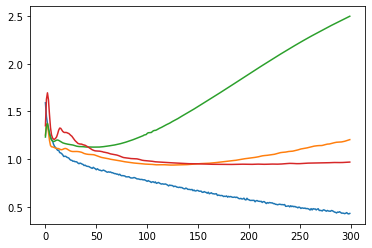

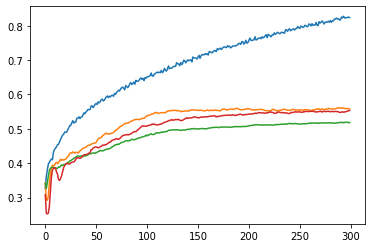

In [921]:
plt.plot(range(len(train_hist_5l_200_lr2.history['loss'])),
         train_hist_5l_200_lr2.history['loss'])
plt.plot(range(len(train_hist_5l_200_lr2.history['val_loss'])),
         train_hist_5l_200_lr2.history['val_loss'])
plt.plot(range(len(train_hist_5l_200_ndrp.history['val_loss'])),
         train_hist_5l_200_ndrp.history['val_loss'])
plt.plot(range(len(train_hist_5l_200_drp2.history['val_loss'])),
         train_hist_5l_200_drp2.history['val_loss'])
plt.show()

plt.plot(range(len(train_hist_5l_200_lr2.history['categorical_accuracy'])),
         train_hist_5l_200_lr2.history['categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200_lr2.history['val_categorical_accuracy'])),
         train_hist_5l_200_lr2.history['val_categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200_ndrp.history['val_categorical_accuracy'])),
         train_hist_5l_200_ndrp.history['val_categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200_drp2.history['val_categorical_accuracy'])),
         train_hist_5l_200_drp2.history['val_categorical_accuracy'])
plt.show()

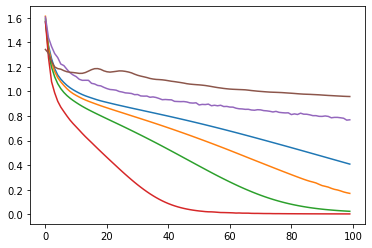

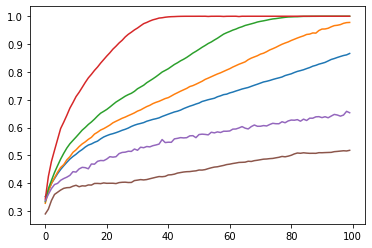

In [908]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_hist.history['loss'])),
         train_hist.history['loss'])
plt.plot(range(len(train_hist_4l.history['loss'])),
         train_hist_4l.history['loss'])
plt.plot(range(len(train_hist_5l.history['loss'])),
         train_hist_5l.history['loss'])
plt.plot(range(len(train_hist_5l_200.history['loss'])),
         train_hist_5l_200.history['loss'])
plt.plot(range(len(train_hist_5l_200_lr2.history['loss'])),
         train_hist_5l_200_lr2.history['loss'])
plt.plot(range(len(train_hist_5l_200_lr2.history['val_loss'])),
         train_hist_5l_200_lr2.history['val_loss'])


plt.show()
plt.plot(range(len(train_hist.history['categorical_accuracy'])),
         train_hist.history['categorical_accuracy'])
plt.plot(range(len(train_hist_4l.history['categorical_accuracy'])),
         train_hist_4l.history['categorical_accuracy'])
plt.plot(range(len(train_hist_5l.history['categorical_accuracy'])),
         train_hist_5l.history['categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200.history['categorical_accuracy'])),
         train_hist_5l_200.history['categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200_lr2.history['categorical_accuracy'])),
         train_hist_5l_200_lr2.history['categorical_accuracy'])
plt.plot(range(len(train_hist_5l_200_lr2.history['val_categorical_accuracy'])),
         train_hist_5l_200_lr2.history['val_categorical_accuracy'])

plt.show()

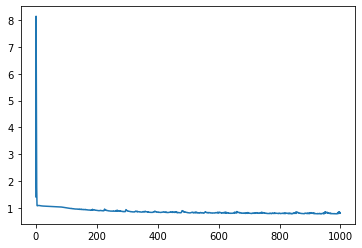

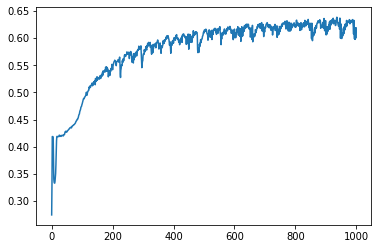

In [271]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_hist.history['loss'])),
         train_hist.history['loss'])
plt.show()
plt.plot(range(len(train_hist.history['categorical_accuracy'])),
         train_hist.history['categorical_accuracy'])
plt.show()

In [107]:
nn_2l300.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 200)               3000      
                                                                 
 batch_normalization_6 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 200)               40200     
                                                                 
 batch_normalization_7 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 200)              

In [879]:
nn_proba_train = nnet.predict(X_train_sc)
pred_classes = nn_proba_train.argmax(axis=1)
nn_pred_train = np.zeros(nn_proba_train.shape).astype(int)
for r in range(nn_proba_train.shape[0]):
    nn_pred_train[r, pred_classes[r]] = 1

380/380 [==============================] - 1s 2ms/step


In [880]:
print(len(pred_classes[pred_classes == 0]))
print(len(pred_classes[pred_classes == 1]))
print(len(pred_classes[pred_classes == 2]))

5081
5627
1429


In [882]:
nn_conf_mtx_train, nn_train_mets = \
    calc_metrics_per_class(y_train, nn_pred_train,
                           classes=y_train.columns.tolist())
display(nn_conf_mtx_train)
display(nn_train_mets)

,none,positive,negative
none,3179,1249,164
positive,869,3641,73
negative,1033,737,1192


,precision,recall,f1
none,0.626,0.692,0.657
positive,0.647,0.794,0.713
negative,0.834,0.402,0.543
macro,0.702,0.629,0.638


In [883]:
nn_proba_test = nnet.predict(X_test_sc)
pred_test_classes = nn_proba_test.argmax(axis=1)
nn_pred_test = np.zeros(nn_proba_test.shape).astype(int)
for r in range(nn_proba_test.shape[0]):
    nn_pred_test[r, pred_test_classes[r]] = 1

nn_conf_mtx_test, nn_test_mets = \
    calc_metrics_per_class(y_test, nn_pred_test,
                           classes=y_test.columns.tolist())
display(nn_conf_mtx_test)
display(nn_test_mets)

163/163 [==============================] - 0s 2ms/step


,none,positive,negative
none,967,842,159
positive,691,1193,81
negative,556,378,335


,precision,recall,f1
none,0.437,0.491,0.462
positive,0.494,0.607,0.545
negative,0.583,0.264,0.363
macro,0.505,0.454,0.457


In [893]:
nn_proba_test = nnet_5l_200.predict(X_test_sc)
pred_test_classes = nn_proba_test.argmax(axis=1)
nn_pred_test = np.zeros(nn_proba_test.shape).astype(int)
for r in range(nn_proba_test.shape[0]):
    nn_pred_test[r, pred_test_classes[r]] = 1

nn_conf_mtx_test, nn_test_mets = \
    calc_metrics_per_class(y_test, nn_pred_test,
                           classes=y_test.columns.tolist())
display(nn_conf_mtx_test)
display(nn_test_mets)

163/163 [==============================] - 0s 2ms/step


,none,positive,negative
none,1311,559,98
positive,988,909,68
negative,708,270,291


,precision,recall,f1
none,0.436,0.666,0.527
positive,0.523,0.463,0.491
negative,0.637,0.229,0.337
macro,0.532,0.453,0.452


In [873]:
def calc_metrics_per_class(y_true, y_pred, classes=None):
    
    if len(y_true.shape) > 1:
        conf_mtx = pd.DataFrame(
            confusion_matrix(
                y_true.values.argmax(axis=1),
                y_pred.argmax(axis=1)
                )
            )
    else:
        conf_mtx = pd.DataFrame(
            confusion_matrix(
                y_true,
                y_pred
                )
            )

    if classes != None:
        conf_mtx.index = classes
        conf_mtx.columns = classes
    else:
        classes = sorted(list(y_true.unique()))
        conf_mtx.index = classes
        conf_mtx.columns = classes

    class_metrics = {}
    for c in classes:
        metrics = {}
        # print(f"{c} : {conf_mtx.loc[c, c]} predicted true",
        #        f", {conf_mtx.loc[:, c].sum()} predicted total",
        #        f", {conf_mtx.loc[c, :].sum()} y real")
        metrics['precision'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[:, c].sum(), 3)
        metrics['recall'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[c, :].sum(), 3)
        metrics['f1'] = \
            round(2 * (metrics['precision'] * metrics['recall'])/
                  (metrics['precision'] + metrics['recall']), 3)
        class_metrics[c] = metrics
        # metrics
    class_metrics = pd.DataFrame(class_metrics)
    macro_metrics = class_metrics.sum(axis=1) / 3
    class_metrics = class_metrics.T
    class_metrics.loc['macro'] = macro_metrics.round(3)
    return conf_mtx, class_metrics

In [875]:
_, test_mets = calc_metrics_per_class(y_test.values.argmax(axis=1), svc_pred_test,
                                      classes=y_test.columns.tolist())
print(test_mets)

          precision  recall     f1
none          0.516   0.535  0.525
positive      0.591   0.617  0.604
negative      0.628   0.548  0.585
macro         0.578   0.567  0.571


In [235]:
def calc_metrics_per_class(y_true, y_pred):
    
    # if len(y_true.shape) > 1:
    #    y_trues = 
    class_metrics = {}
    conf_mtx = pd.DataFrame(
        confusion_matrix(
            y_true.values.argmax(axis=1),
            y_pred.argmax(axis=1)
            ),
        index=y_true.columns.tolist(),
        columns = y_true.columns.tolist()
        )
    for c in conf_mtx.columns.tolist():
        metrics = {}
        # print(f"{c} : {conf_mtx.loc[c, c]} predicted true",
        #        f", {conf_mtx.loc[:, c].sum()} predicted total",
        #        f", {conf_mtx.loc[c, :].sum()} y real")
        metrics['precision'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[:, c].sum(), 3)
        metrics['recall'] = \
            round(conf_mtx.loc[c, c] / conf_mtx.loc[c, :].sum(), 3)
        metrics['f1'] = \
            round(2 * (metrics['precision'] * metrics['recall'])/
                  (metrics['precision'] + metrics['recall']), 3)
        class_metrics[c] = metrics
        
        
        # metrics
    class_metrics = pd.DataFrame(class_metrics)
    return conf_mtx, class_metrics.T

In [182]:
conf_test , test_metrics = calc_metrics_per_class(y_test, nn_pred_test)
display(conf_test)
display(test_metrics)

none : 1910 predicted true
none : 5828 predicted total
none : 1967 y real
positive : 44 predicted true
positive : 129 predicted total
positive : 2494 y real
negative : 0 predicted true
negative : 0 predicted total
negative : 1496 y real


/tmp/ipykernel_686377/2410762427.py:17: RuntimeWarning: invalid value encountered in long_scalars
  round(conf_mtx.loc[c, c] / conf_mtx.loc[:, c].sum(), 3)


,none,positive,negative
none,1910,57,0
positive,2450,44,0
negative,1468,28,0


,precision,recall,f1
none,0.328,0.971,0.490
positive,0.341,0.018,0.034
negative,NaN,0.000,NaN


In [176]:
nn_pred_test.sum(axis=0)

array([5828,  129,    0])

In [174]:
class_report_test = metrics.classification_report(y_test, nn_pred_test, digits=3)
print(class_report_test)

              precision    recall  f1-score   support

           0      0.328     0.971     0.490      1967
           1      0.341     0.018     0.034      2494
           2      0.000     0.000     0.000      1496

   micro avg      0.328     0.328     0.328      5957
   macro avg      0.223     0.330     0.175      5957
weighted avg      0.251     0.328     0.176      5957
 samples avg      0.328     0.328     0.328      5957



/home/graymo/.cache/pypoetry/virtualenvs/emotion-eq9CsLJl-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
conf_test = calc_metrics_per_class(y_test, nn_pred_test)
display(conf_test)

,none,positive,negative
none,618,1053,296
positive,443,1858,193
negative,271,635,590


In [163]:
print(y_test.sum(axis=0))
print(conf_test.sum(axis=1))

none        1967
positive    2494
negative    1496
dtype: int64
none        1967
positive    2494
negative    1496
dtype: int64


In [275]:
nn_proba_test = nnet.predict(X_test)
pred_classes = nn_proba_test.argmax(axis=1)
nn_pred_test = np.zeros(nn_proba_test.shape).astype(int)
for r in range(nn_proba_test.shape[0]):
    nn_pred_test[r, pred_classes[r]] = 1

187/187 [==============================] - 0s 1ms/step


In [276]:
nn_conf_mtx_test, nn_tst_mets = calc_metrics_per_class(y_test, nn_pred_test)
display(nn_conf_mtx_test)
display(nn_tst_mets)

none : 1289 predicted true , 4082 predicted total , 1967 y real
positive : 743 predicted true , 1863 predicted total , 2494 y real
negative : 3 predicted true , 12 predicted total , 1496 y real


,none,positive,negative
none,1289,672,6
positive,1748,743,3
negative,1045,448,3


,precision,recall,f1
none,0.316,0.655,0.426
positive,0.399,0.298,0.341
negative,0.250,0.002,0.004


In [102]:
nn_conf_mtx_test, nn_tst_mets = per_class_metrics(y_test, nn_pred_test)
display(nn_conf_mtx_test)
display(nn_tst_mets)

/tmp/ipykernel_686377/2000006072.py:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = pred_count.loc[c, c] / pred_count.loc[c].sum()


,none,positive,negative
none,1910,2450,1468
positive,57,44,28
negative,0,0,0


,precision,recall,F1
none,0.327728,0.971022,0.490058
positive,0.341085,0.017642,0.033549
negative,NaN,0.000000,NaN


In [74]:
! poetry list

Poetry (version 1.2.0b1)

Usage:
  command [options] [arguments]

Options:
  -h, --help            Display help for the given command. When no command is given display help for the list command.
  -q, --quiet           Do not output any message.
  -V, --version         Display this application version.
      --ansi            Force ANSI output.
      --no-ansi         Disable ANSI output.
  -n, --no-interaction  Do not ask any interactive question.
      --no-plugins      Disables plugins.
  -v|vv|vvv, --verbose  Increase the verbosity of messages: 1 for normal output, 2 for more verbose output and 3 for debug.

Available commands:
  about          Shows information about Poetry.
  add            Adds a new dependency to pyproject.toml.
  build          Builds a package, as a tarball and a wheel by default.
  check          Checks the validity of the pyproject.toml file.
  config         Manages configuration settings.
  export         Exports the lock file to alternative formats.
  he

In [75]:
! poetry plugin show